# Import

In [32]:
%load_ext autoreload
%autoreload 2
from torch.utils.data import DataLoader
import torch
import pytorch_lightning as pl
from pathlib import Path
import os
import time
import datetime
import yaml
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

import logging

from tqdm.notebook import tqdm

import volpick.model.models as models
import seisbench.models as sbm
import seisbench.generate as sbg
from volpick.model.utils import load_best_model_from_base_dir,load_best_model,plot_prediction_examples
import seisbench.data as sbd
from volpick.model.generate_eval_targets import generate_task0, generate_task1, generate_task23

from obspy.signal.trigger import recursive_sta_lta, trigger_onset
from volpick.model.models import phase_dict
from volpick.model.eval_taks0 import evaluate, get_ground_truth, count_TP_FP_FN, compute_residuals, calculate_precision_recall_F1score, eval_task0, opt_prob_metrics, collect_task0_results,collect_task0_results_dev
from volpick.model.eval_taks123 import eval_tasks123,collect_task123_results

import json

from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
def lteq(a, b):
    """return a<=b"""
    return (a < b) | (abs(a - b) < 1e-12)  # parentheses are important!!!


print(lteq(10, 20))
print(lteq(np.array([10.0, 20.0]), 20.0))

True
[ True  True]


# Load data

In [34]:
data_path = Path("/home/zhongyiyuan/DATA/my_datasets_seisbench/westernus")

dataset = sbd.WaveformDataset(
    data_path,
    sampling_rate=100,
    component_order="ZNE",
    dimension_order="NCW",
    cache="full",
)
dataset.filter(dataset["split"].isin(["test"]), inplace=True)
dataset.preload_waveforms(pbar=True)

# print(len(dataset))

Preloading waveforms: 100%|██████████| 11302/11302 [00:02<00:00, 4932.93it/s]


In [35]:
data_eq = dataset.filter(dataset["source_type"] != "noise", inplace=False).test()
np.all((data_eq["split"] == "test").values)

True

In [36]:
data_path = Path("/home/zhongyiyuan/DATA/my_datasets_seisbench/westernus")

dataset_ENZ = sbd.WaveformDataset(
    data_path,
    sampling_rate=100,
    component_order="ENZ",
    dimension_order="NCW",
    cache="full",
)
dataset_ENZ.filter(dataset_ENZ["split"].isin(["test"]), inplace=True)
dataset_ENZ.preload_waveforms(pbar=True)

Preloading waveforms: 100%|██████████| 11302/11302 [00:01<00:00, 5683.11it/s]


In [61]:
data_eq_lp = data_eq.filter(
    (data_eq.metadata["source_type"] == "lp"),
    inplace=False,
)
data_eq_rg = data_eq.filter(
    (data_eq.metadata["source_type"] != "lp"),
    inplace=False,
)

In [37]:
data_eq_ENZ = dataset_ENZ.filter(
    dataset_ENZ["source_type"] != "noise", inplace=False
).test()
np.all((data_eq_ENZ["split"] == "test").values)

True

In [62]:
data_eq_ENZ_lp = data_eq_ENZ.filter(
    (data_eq_ENZ.metadata["source_type"] == "lp"),
    inplace=False,
)
data_eq_ENZ_rg = data_eq_ENZ.filter(
    (data_eq_ENZ.metadata["source_type"] != "lp"),
    inplace=False,
)

# Load models

In [39]:
vol_eqt = sbm.EQTransformer.from_pretrained("volpick")
vol_eqt.cuda()
vol_pn = sbm.PhaseNet.from_pretrained("volpick")
vol_pn.cuda()
print(vol_eqt.labels)
print(vol_pn.labels)
print(vol_eqt.norm)
print(vol_pn.norm)
print(vol_eqt.device)
print(vol_pn.device)

['Detection', 'P', 'S']
PSN
peak
peak
cuda:0
cuda:0


In [40]:
org_eqt = sbm.EQTransformer.from_pretrained("original")
org_eqt2 = sbm.EQTransformer.from_pretrained("original_nonconservative")
org_pn = sbm.PhaseNet.from_pretrained("original")
org_eqt.cuda()
org_eqt2.cuda()
org_pn.cuda()
print(org_eqt.labels)
print(org_eqt2.labels)
print(org_pn.labels)
print(org_eqt.norm)
print(org_eqt2.norm)
print(org_pn.norm)
print(org_eqt.device)
print(org_eqt2.device)
print(org_pn.device)

eqt_instance = sbm.EQTransformer.from_pretrained("instance")
pn_instance = sbm.PhaseNet.from_pretrained("instance")
eqt_instance.cuda()
pn_instance.cuda()
print(eqt_instance.labels)
print(pn_instance.labels)
print(eqt_instance.norm)
print(pn_instance.norm)
print(eqt_instance.device)
print(pn_instance.device)

['Detection', 'P', 'S']
['Detection', 'P', 'S']
NPS
std
std
std
cuda:0
cuda:0
cuda:0
['Detection', 'P', 'S']
PSN
peak
peak
cuda:0
cuda:0


# Figure saving path

In [41]:
root_save_path = Path("./")
try:
    root_save_path.mkdir(parents=True, exist_ok=False)
except FileExistsError:
    print(f"{root_save_path} exists")

. exists


# Frequency index

In [10]:
freq_indices = data_eq.metadata.drop_duplicates(
    subset="source_id", keep="first", inplace=False
)["source_frequency_index"].to_numpy()
source_ids = data_eq.metadata.drop_duplicates(
    subset="source_id", keep="first", inplace=False
)["source_id"].to_numpy()

# lp and vt
lp_metadata = data_eq.metadata[data_eq.metadata["source_type"] == "lp"]
rg_metadata = data_eq.metadata[data_eq.metadata["source_type"] != "lp"]
print(len(lp_metadata))
print(len(rg_metadata))

# frequency indexes of lp events and vt events
freq_indices_lp = lp_metadata.drop_duplicates(
    subset="source_id", keep="first", inplace=False
)["source_frequency_index"].to_numpy()
freq_indices_rg = rg_metadata.drop_duplicates(
    subset="source_id", keep="first", inplace=False
)["source_frequency_index"].to_numpy()

5651
5651


In [11]:
# frequency index for each trace
trace_freq_indices = data_eq.metadata["trace_frequency_index"]
trace_freq_indices_lp = lp_metadata["trace_frequency_index"]
trace_freq_indices_rg = rg_metadata["trace_frequency_index"]

In [12]:
print(f"Total {len(freq_indices)}")
print(f"LP: {len(freq_indices_lp)}")
print(f"VT: {len(freq_indices_rg)}")

# validate
print(len(freq_indices_rg) + len(freq_indices_lp) == len(freq_indices))
print(
    np.all(
        np.sort(np.concatenate((freq_indices_rg, freq_indices_lp)))
        == np.sort(freq_indices)
    )
)
# print(np.sum(np.sort(np.concatenate((freq_indices_rg, freq_indices_lp)))-np.sort(freq_indices)))

print(
    len(trace_freq_indices_rg) + len(trace_freq_indices_lp) == len(trace_freq_indices)
)
print(
    np.all(
        np.sort(np.concatenate((trace_freq_indices_rg, trace_freq_indices_lp)))
        == np.sort(trace_freq_indices)
    )
)
# print(np.sum(np.sort(np.concatenate((trace_freq_indices_rg, trace_freq_indices_lp)))-np.sort(trace_freq_indices)))

Total 3164
LP: 1295
VT: 1869
True
True
True
True


max 1.7326133191762194
min -5.279731596357192
max 1.239009965703311
min -4.787927541635342


Text(0, 0.5, 'Count')

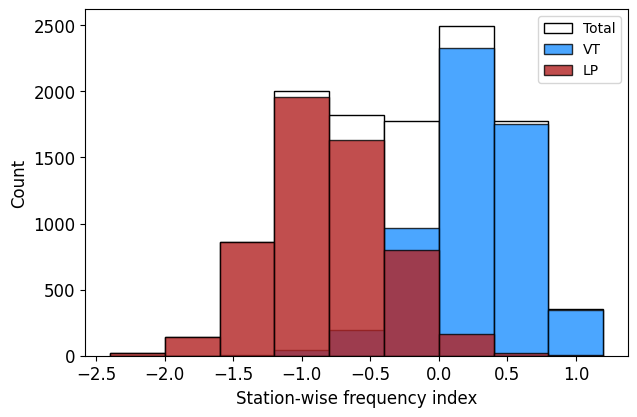

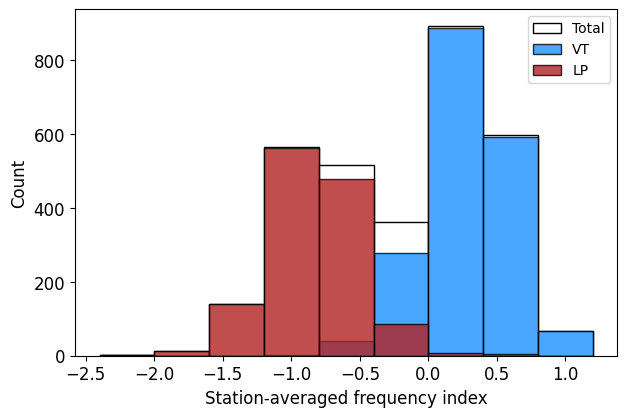

In [13]:
print(f"max {np.max(trace_freq_indices)}")
print(f"min {np.min(trace_freq_indices)}")
fts = 12
fig = plt.figure(figsize=(7, 4.5))

bins = np.arange(-2.4, 1.5, 0.4)
plt.hist(
    trace_freq_indices,
    bins,
    density=False,
    stacked=True,
    color="white",
    edgecolor="black",
    label="Total",
)
plt.hist(
    trace_freq_indices_rg,
    bins,
    density=False,
    edgecolor="black",
    color="dodgerblue",
    alpha=0.8,
    label="VT",
)
plt.hist(
    trace_freq_indices_lp,
    bins,
    density=False,
    edgecolor="black",
    color="firebrick",
    alpha=0.8,
    label="LP",
)
plt.gca().tick_params(labelsize=fts)
plt.legend()
plt.xlabel("Station-wise frequency index", fontsize=fts)
plt.ylabel("Count", fontsize=fts)
# plt.savefig(root_save_path / "FI_by_traces.jpg", bbox_inches="tight", dpi=600)
# plt.savefig(root_save_path/"FI_by_traces.eps", bbox_inches="tight", dpi=600)

print(f"max {np.max(freq_indices)}")
print(f"min {np.min(freq_indices)}")
fts = 12
fig = plt.figure(figsize=(7, 4.5))


plt.hist(
    freq_indices, bins, density=False, color="white", edgecolor="black", label="Total"
)
plt.hist(
    freq_indices_rg,
    bins,
    density=False,
    color="dodgerblue",
    edgecolor="black",
    alpha=0.8,
    label="VT",
)
plt.hist(
    freq_indices_lp,
    bins,
    density=False,
    color="firebrick",
    edgecolor="black",
    alpha=0.8,
    label="LP",
)
# plt.gca().axhline(200)

plt.gca().tick_params(labelsize=fts)
plt.legend()
plt.xlabel("Station-averaged frequency index", fontsize=fts)
plt.ylabel("Count", fontsize=fts)
# plt.savefig(
#     root_save_path / "FI_averaged_over_stations.jpg", bbox_inches="tight", dpi=600
# )

# Evaluation

In [14]:
bins = np.arange(-2.4, 1.5, 0.4)
for x, y in zip(bins[:-1], bins[1:]):
    print(f"{x:15e}, {y:15e}")

  -2.400000e+00,   -2.000000e+00
  -2.000000e+00,   -1.600000e+00
  -1.600000e+00,   -1.200000e+00
  -1.200000e+00,   -8.000000e-01
  -8.000000e-01,   -4.000000e-01
  -4.000000e-01,   -4.440892e-16
  -4.440892e-16,    4.000000e-01
   4.000000e-01,    8.000000e-01
   8.000000e-01,    1.200000e+00


(array([162., 187., 104., 110., 125., 135., 114., 144., 136., 130., 104.,
        135., 119.,  86.,  60.,  95.,  67.,  49.,  96.,  48.,  48.,  28.,
         71.,  26.,  66.,  48.,  40.,  25.,  74.,  62.,  31.,  32.,  22.,
         37.,  36.,  56.,  39.,  53.,  47.,  68.,  52.,  70., 106.,  83.,
         66.,  55.,  59.,  75.,  99.,  74.]),
 array([-0.79937779, -0.78141331, -0.76344884, -0.74548436, -0.72751988,
        -0.70955541, -0.69159093, -0.67362645, -0.65566197, -0.6376975 ,
        -0.61973302, -0.60176854, -0.58380407, -0.56583959, -0.54787511,
        -0.52991063, -0.51194616, -0.49398168, -0.4760172 , -0.45805272,
        -0.44008825, -0.42212377, -0.40415929, -0.38619482, -0.36823034,
        -0.35026586, -0.33230138, -0.31433691, -0.29637243, -0.27840795,
        -0.26044348, -0.242479  , -0.22451452, -0.20655004, -0.18858557,
        -0.17062109, -0.15265661, -0.13469213, -0.11672766, -0.09876318,
        -0.0807987 , -0.06283423, -0.04486975, -0.02690527, -0.00894079,
 

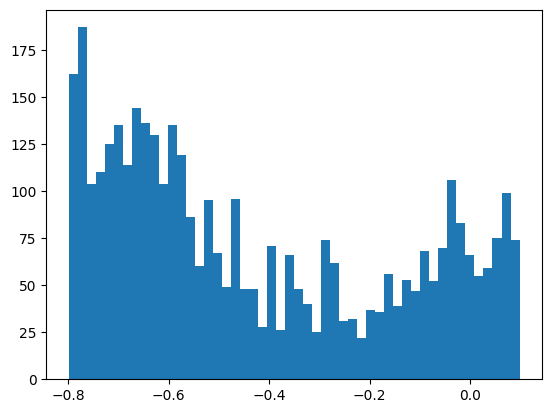

In [15]:
plt.hist(
    data_eq.metadata[
        (data_eq.metadata["source_frequency_index"] > -0.8)
        & (lteq(data_eq.metadata["source_frequency_index"], 0.1))
    ]["source_frequency_index"],
    50,
)

In [16]:
data_eq["trace_name"]

0           bucket0$0,:3,:4334
1           bucket1$0,:3,:4604
2           bucket1$1,:3,:4604
3           bucket1$2,:3,:4604
4           bucket1$3,:3,:4604
                 ...          
11297    bucket5$364,:3,:12067
11298    bucket5$365,:3,:12281
11299    bucket5$366,:3,:12210
11300    bucket5$367,:3,:12281
11301    bucket5$368,:3,:12166
Name: trace_name, Length: 11302, dtype: object

## Predict

In [17]:
bins

array([-2.4000000e+00, -2.0000000e+00, -1.6000000e+00, -1.2000000e+00,
       -8.0000000e-01, -4.0000000e-01, -4.4408921e-16,  4.0000000e-01,
        8.0000000e-01,  1.2000000e+00])

In [18]:
tp_thre = 0.5
print(bins)
t1 = time.perf_counter()
FIstrings = []
FIs_midpoint = []
num_seis = {}
for x, y in zip(bins[:-1], bins[1:]):
    mask = (data_eq.metadata["source_frequency_index"] > x) & (
        lteq(data_eq.metadata["source_frequency_index"], y)
    )

    sub_dataset = data_eq.filter(mask, inplace=False)

    mask2 = (data_eq_ENZ.metadata["source_frequency_index"] > x) & (
        lteq(data_eq_ENZ.metadata["source_frequency_index"], y)
    )
    sub_dataset_ENZ = data_eq_ENZ.filter(mask2, inplace=False)
    if len(sub_dataset) > 0:
        fi_str = f"({x:.1f},{y:.1f}]"
        # FI_dataset_map[f"{0.5*(x+y):.2f}"]=sub_dataset
        FIstrings.append(fi_str)
        FIs_midpoint.append(0.5 * (x + y))
        print(fi_str, len(sub_dataset))
        num_seis[fi_str] = len(sub_dataset)

        # sub_dataset._metadata["split"]="test"

        targets_path_fi = root_save_path / f"{fi_str}"
        try:
            targets_path_fi.mkdir(parents=True, exist_ok=False)
        except FileExistsError:
            print(f"{targets_path_fi} exists")
        generate_task0(
            dataset=sub_dataset,
            output=targets_path_fi,
            sampling_rate=100,
            noise_before_events=False,
            replace_if_exist=True,
        )

        # for model in original_model_list:
        #     eval_task0(dev_test_set=sub_dataset,
        #                 model=model,
        #                 exp_name=f"{model.name}_original",
        #                 targets_path=targets_path_fi,
        #                 prob_thres=np.array([0.2, 0.225, 0.25,0.275, 0.3,0.35, 0.4, 0.5]),
        #                 num_workers=16,
        #                 batchsize=2048,
        #                 num_test_run=-1,
        #                 output_remark="pred",
        #                 sets=["test"],
        #                 data_norm_type=model.norm)

        # retrained eqt

        model = vol_eqt
        # for target_i, dataset_i in zip(target_path_list,dataset_list):
        eval_task0(
            dev_test_set=sub_dataset,
            model=model,
            exp_name=f"vol_eqt",
            targets_path=targets_path_fi,
            prob_thres=np.array([0.22]),
            num_workers=16,
            batchsize=2048,
            num_test_run=-1,
            output_remark="pred",
            tp_thre=tp_thre,
            sets=["test"],
            data_norm_type=model.norm,
        )

        model = vol_pn
        eval_task0(
            dev_test_set=sub_dataset,
            model=model,
            exp_name=f"vol_pn",
            targets_path=targets_path_fi,
            prob_thres=np.array([0.39, 0.34]),
            num_workers=16,
            batchsize=2048,
            num_test_run=-1,
            output_remark="pred",
            tp_thre=tp_thre,
            sets=["test"],
            data_norm_type=model.norm,
        )

        model = org_eqt2
        eval_task0(
            dev_test_set=sub_dataset,
            model=model,
            exp_name=f"org_eqt",
            targets_path=targets_path_fi,
            prob_thres=np.array([0.26, 0.15]),
            num_workers=16,
            batchsize=2048,
            num_test_run=-1,
            output_remark="pred",
            tp_thre=tp_thre,
            sets=["test"],
            # sets=["train", "dev","test"],
            # append_to_file=True,
            data_norm_type=model.norm,
        )

        model = org_pn
        eval_task0(
            dev_test_set=sub_dataset_ENZ,
            model=model,
            exp_name=f"org_pn",
            targets_path=targets_path_fi,
            prob_thres=np.array([0.25, 0.19]),
            num_workers=16,
            batchsize=1024,
            num_test_run=-1,
            output_remark="pred",
            tp_thre=tp_thre,
            sets=["test"],
            # sets=["train", "dev","test"],
            # append_to_file=True,
            data_norm_type=model.norm,
        )

        model = eqt_instance
        eval_task0(
            dev_test_set=sub_dataset,
            model=model,
            exp_name=f"int_eqt",
            targets_path=targets_path_fi,
            prob_thres=np.array([0.04]),
            num_workers=16,
            batchsize=1024,
            num_test_run=-1,
            output_remark="pred",
            tp_thre=tp_thre,
            sets=["test"],
            # sets=["train", "dev","test"],
            # append_to_file=True,
            data_norm_type=model.norm,
        )

        model = pn_instance
        eval_task0(
            dev_test_set=sub_dataset,
            model=model,
            exp_name=f"int_pn",
            targets_path=targets_path_fi,
            prob_thres=np.array([0.13, 0.05]),
            num_workers=16,
            batchsize=1024,
            num_test_run=-1,
            output_remark="pred",
            tp_thre=tp_thre,
            sets=["test"],
            # sets=["train", "dev","test"],
            # append_to_file=True,
            data_norm_type=model.norm,
        )

t2 = time.perf_counter()
running_time = str(datetime.timedelta(seconds=t2 - t1))
print(f"Finished. Runing time {running_time}")

[-2.4000000e+00 -2.0000000e+00 -1.6000000e+00 -1.2000000e+00
 -8.0000000e-01 -4.0000000e-01 -4.4408921e-16  4.0000000e-01
  8.0000000e-01  1.2000000e+00]
(-2.4,-2.0] 9


100%|██████████| 9/9 [00:00<00:00, 2197.89it/s]


(-2.4,-2.0]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 9/9 [00:00<00:00, 90742.15it/s]

Number of examples in test: 9
9 earthquake traces
0 noise traces
Probability threshold: 0.2200


(-2.4,-2.0]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 9/9 [00:00<00:00, 81355.03it/s]

Number of examples in test: 9
9 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
(-2.4,-2.0]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 9/9 [00:00<00:00, 67893.41it/s]

Number of examples in test: 9
9 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
(-2.4,-2.0]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 9/9 [00:00<00:00, 36331.80it/s]

Number of examples in test: 9
9 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
(-2.4,-2.0]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 9/9 [00:00<00:00, 90742.15it/s]

Number of examples in test: 9
9 earthquake traces
0 noise traces
Probability threshold: 0.0400


(-2.4,-2.0]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 9/9 [00:00<00:00, 43489.33it/s]

Number of examples in test: 9
9 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
(-2.0,-1.6] 43


100%|██████████| 43/43 [00:00<00:00, 2697.83it/s]


(-2.0,-1.6]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 43/43 [00:00<00:00, 77107.77it/s]

Number of examples in test: 43
43 earthquake traces
0 noise traces
Probability threshold: 0.2200


(-2.0,-1.6]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 43/43 [00:00<00:00, 206592.29it/s]

Number of examples in test: 43
43 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
(-2.0,-1.6]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 43/43 [00:00<00:00, 113573.72it/s]

Number of examples in test: 43
43 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
(-2.0,-1.6]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 43/43 [00:00<00:00, 107226.56it/s]

Number of examples in test: 43
43 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
(-2.0,-1.6]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 43/43 [00:00<00:00, 201289.14it/s]

Number of examples in test: 43
43 earthquake traces
0 noise traces
Probability threshold: 0.0400


(-2.0,-1.6]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 43/43 [00:00<00:00, 80122.20it/s]

Number of examples in test: 43
43 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
(-1.6,-1.2] 555


100%|██████████| 555/555 [00:00<00:00, 2675.37it/s]


(-1.6,-1.2]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 555/555 [00:00<00:00, 212704.56it/s]

Number of examples in test: 555
555 earthquake traces
0 noise traces
Probability threshold: 0.2200


(-1.6,-1.2]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 555/555 [00:00<00:00, 263897.37it/s]

Number of examples in test: 555
555 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
(-1.6,-1.2]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 555/555 [00:00<00:00, 163437.39it/s]

Number of examples in test: 555
555 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
(-1.6,-1.2]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 555/555 [00:00<00:00, 245863.83it/s]

Number of examples in test: 555
555 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
(-1.6,-1.2]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 555/555 [00:00<00:00, 352329.15it/s]

Number of examples in test: 555
555 earthquake traces
0 noise traces
Probability threshold: 0.0400


(-1.6,-1.2]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 555/555 [00:00<00:00, 331742.73it/s]

Number of examples in test: 555
555 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
(-1.2,-0.8] 2494


100%|██████████| 2494/2494 [00:01<00:00, 2050.72it/s]


(-1.2,-0.8]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 2494/2494 [00:00<00:00, 360498.82it/s]

Number of examples in test: 2493
2493 earthquake traces
0 noise traces
Probability threshold: 0.2200


(-1.2,-0.8]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 2494/2494 [00:00<00:00, 357798.41it/s]

Number of examples in test: 2493
2493 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
(-1.2,-0.8]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 2494/2494 [00:00<00:00, 360959.08it/s]

Number of examples in test: 2493
2493 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
(-1.2,-0.8]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 2494/2494 [00:00<00:00, 360623.10it/s]

Number of examples in test: 2493
2493 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
(-1.2,-0.8]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 2494/2494 [00:00<00:00, 367502.61it/s]

Number of examples in test: 2493
2493 earthquake traces
0 noise traces
Probability threshold: 0.0400


(-1.2,-0.8]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 2494/2494 [00:00<00:00, 289638.78it/s]

Number of examples in test: 2493
2493 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
(-0.8,-0.4] 2292


100%|██████████| 2292/2292 [00:01<00:00, 2086.07it/s]


(-0.8,-0.4]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 2292/2292 [00:00<00:00, 135113.77it/s]

Number of examples in test: 2292
2292 earthquake traces
0 noise traces
Probability threshold: 0.2200


(-0.8,-0.4]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 2292/2292 [00:00<00:00, 365345.83it/s]

Number of examples in test: 2292
2292 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
(-0.8,-0.4]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 2292/2292 [00:00<00:00, 366166.86it/s]

Number of examples in test: 2292
2292 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
(-0.8,-0.4]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 2292/2292 [00:00<00:00, 362535.16it/s]

Number of examples in test: 2292
2292 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
(-0.8,-0.4]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 2292/2292 [00:00<00:00, 358172.31it/s]

Number of examples in test: 2292
2292 earthquake traces
0 noise traces
Probability threshold: 0.0400


(-0.8,-0.4]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 2292/2292 [00:00<00:00, 150939.63it/s]

Number of examples in test: 2292
2292 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
(-0.4,-0.0] 1169


100%|██████████| 1169/1169 [00:00<00:00, 2111.59it/s]


(-0.4,-0.0]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 1169/1169 [00:00<00:00, 252674.12it/s]

Number of examples in test: 1169
1169 earthquake traces
0 noise traces
Probability threshold: 0.2200


(-0.4,-0.0]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 1169/1169 [00:00<00:00, 349999.38it/s]

Number of examples in test: 1169
1169 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
(-0.4,-0.0]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 1169/1169 [00:00<00:00, 367029.07it/s]

Number of examples in test: 1169
1169 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
(-0.4,-0.0]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 1169/1169 [00:00<00:00, 249358.76it/s]

Number of examples in test: 1169
1169 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
(-0.4,-0.0]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 1169/1169 [00:00<00:00, 351757.04it/s]

Number of examples in test: 1169
1169 earthquake traces
0 noise traces
Probability threshold: 0.0400


(-0.4,-0.0]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 1169/1169 [00:00<00:00, 265839.37it/s]

Number of examples in test: 1169
1169 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
(-0.0,0.4] 2867


100%|██████████| 2867/2867 [00:01<00:00, 1854.22it/s]


(-0.0,0.4]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 2867/2867 [00:00<00:00, 342000.22it/s]

Number of examples in test: 2867
2867 earthquake traces
0 noise traces
Probability threshold: 0.2200


(-0.0,0.4]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 2867/2867 [00:00<00:00, 358882.31it/s]

Number of examples in test: 2867
2867 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
(-0.0,0.4]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 2867/2867 [00:00<00:00, 372870.37it/s]

Number of examples in test: 2867
2867 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
(-0.0,0.4]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 2867/2867 [00:00<00:00, 354952.17it/s]

Number of examples in test: 2867
2867 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
(-0.0,0.4]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 2867/2867 [00:00<00:00, 358336.90it/s]

Number of examples in test: 2867
2867 earthquake traces
0 noise traces
Probability threshold: 0.0400


(-0.0,0.4]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 2867/2867 [00:00<00:00, 357867.67it/s]

Number of examples in test: 2867
2867 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
(0.4,0.8] 1758


100%|██████████| 1758/1758 [00:00<00:00, 1874.03it/s]


(0.4,0.8]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 1758/1758 [00:00<00:00, 357888.97it/s]

Number of examples in test: 1758
1758 earthquake traces
0 noise traces
Probability threshold: 0.2200


(0.4,0.8]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 1758/1758 [00:00<00:00, 361361.75it/s]

Number of examples in test: 1758
1758 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
(0.4,0.8]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 1758/1758 [00:00<00:00, 369085.32it/s]

Number of examples in test: 1758
1758 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
(0.4,0.8]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 1758/1758 [00:00<00:00, 370290.08it/s]

Number of examples in test: 1758
1758 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
(0.4,0.8]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 1758/1758 [00:00<00:00, 366626.21it/s]

Number of examples in test: 1758
1758 earthquake traces
0 noise traces
Probability threshold: 0.0400


(0.4,0.8]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 1758/1758 [00:00<00:00, 354960.11it/s]

Number of examples in test: 1758
1758 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
(0.8,1.2] 111


100%|██████████| 111/111 [00:00<00:00, 1581.01it/s]


(0.8,1.2]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 111/111 [00:00<00:00, 292258.47it/s]

Number of examples in test: 111
111 earthquake traces
0 noise traces
Probability threshold: 0.2200


(0.8,1.2]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 111/111 [00:00<00:00, 297107.69it/s]

Number of examples in test: 111
111 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
(0.8,1.2]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 111/111 [00:00<00:00, 153703.45it/s]

Number of examples in test: 111
111 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
(0.8,1.2]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 111/111 [00:00<00:00, 288993.01it/s]

Number of examples in test: 111
111 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
(0.8,1.2]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 111/111 [00:00<00:00, 290616.57it/s]

Number of examples in test: 111
111 earthquake traces
0 noise traces
Probability threshold: 0.0400


(0.8,1.2]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 111/111 [00:00<00:00, 292442.05it/s]

Number of examples in test: 111
111 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
Finished. Runing time 0:07:47.769970


In [19]:
def str2list(str_list):
    return [float(x.strip()) for x in str_list.lstrip("[").rstrip("]").split(",")]


avg_snrs = []
median_snrs = []
min_snrs = []
max_snrs = []
snr_10p = []
snr_90p = []
for x, y in zip(bins[:-1], bins[1:]):
    # print(x,y)
    mask = (data_eq.metadata["source_frequency_index"] > x) & (
        lteq(data_eq.metadata["source_frequency_index"], y)
    )
    group = data_eq.metadata[mask].copy()

    snr_zne = group["trace_snr_db"].apply(str2list)
    snr_zne = snr_zne[snr_zne.apply(lambda x: not np.all(pd.isna(np.array(x))))]
    snr = snr_zne.apply(np.nanmean)
    snr = snr[pd.notna(snr)]

    avg_snrs.append(np.average(snr.values))
    median_snrs.append(np.median(snr.values))
    min_snrs.append(np.min(snr.values))
    max_snrs.append(np.max(snr.values))
    snr_10p.append(np.percentile(snr.values, 10))
    snr_90p.append(np.percentile(snr.values, 90))

df_snr = pd.DataFrame(
    data={
        "FI_interval": FIstrings,
        "FI": FIs_midpoint,
        "mean_snr": avg_snrs,
        "median_snr": median_snrs,
        "min_snr": min_snrs,
        "max_snr": max_snrs,
        "10_percentile": snr_10p,
        "90_percentile": snr_90p,
    }
)
df_snr.to_csv("snr_vs_fi.csv", index=False)

In [20]:
snr

1429     24.431775
6489     34.003495
6587     33.208426
6615     16.665077
6693     16.441540
           ...    
11062    51.740769
11109    18.991094
11110    15.564379
11189     0.944967
11236    11.790396
Name: trace_snr_db, Length: 111, dtype: float64

In [21]:
df_snr

,FI_interval,FI,mean_snr,median_snr,min_snr,max_snr,10_percentile,90_percentile
0,"(-2.4,-2.0]",-2.2,15.444793,11.225681,0.926402,35.604887,1.968209,34.615927
1,"(-2.0,-1.6]",-1.8,13.764862,11.747166,-1.100452,32.429762,3.011459,27.496980
2,"(-1.6,-1.2]",-1.4,11.926262,11.249587,-4.429147,40.301330,1.832228,23.144082
3,"(-1.2,-0.8]",-1.0,8.785431,7.635819,-7.942316,42.936345,0.275324,18.804776
4,"(-0.8,-0.4]",-0.6,7.991922,6.400823,-18.427904,82.558544,0.114751,16.639207
5,"(-0.4,-0.0]",-0.2,17.529072,13.722259,-10.492208,82.431486,1.396756,39.952053
6,"(-0.0,0.4]",0.2,26.198373,24.036731,-6.256690,77.771447,6.525824,48.885780
7,"(0.4,0.8]",0.6,24.725404,23.138203,-6.192364,66.002977,7.086497,45.046814
8,"(0.8,1.2]",1.0,16.698535,14.591953,0.792620,51.740769,6.786891,29.251595


In [22]:
with open(root_save_path / "FI_intervals.txt", "w") as FIs_file:
    for x in FIstrings:
        FIs_file.write(f"{x}\n")

# Collect results

In [23]:
opt_thresholds_for_original_models_df = pd.read_csv(
    "/home/zhongyiyuan/volpick/model_training/Original_model_opt_thresholds/all_pred/task0/optimal_threshold.csv"
)
opt_thresholds_for_original_models_df = opt_thresholds_for_original_models_df[
    ["exp_name", "model", "p_opt_prob_thre", "s_opt_prob_thre"]  # "pretraining",
]
opt_thresholds_for_original_models_df

,exp_name,model,p_opt_prob_thre,s_opt_prob_thre
0,PhaseNet_org_instance,PhaseNet,0.13,0.050
1,PhaseNet_org_incorrect_component_order,PhaseNet,0.28,0.170
2,EQTransformer_org,EQTransformer,0.01,0.001
3,EQTransformer_org_instance,EQTransformer,0.04,0.040
4,PhaseNet_org,PhaseNet,0.25,0.190
5,EQTransformer_org_nonconservative,EQTransformer,0.26,0.150
6,PhaseNet_org_stead,PhaseNet,0.01,0.040
7,EQTransformer_org_stead,EQTransformer,0.02,0.010


In [24]:
eqt_pred_dirs = ["org_eqt", "int_eqt", "vol_eqt"]
pn_pred_dirs = ["org_pn", "int_pn", "vol_pn"]
exp_names = eqt_pred_dirs + pn_pred_dirs

save_csv_names = {
    "org_pn": "org_pn_fi.csv",
    "int_pn": "int_pn_fi.csv",
    "vol_pn": "vol_pn_fi.csv",
    "org_eqt": "org_eqt_fi.csv",
    "vol_eqt": "vol_eqt_fi.csv",
    "int_eqt": "int_eqt_fi.csv",
}
p_thre_dict = {
    "vol_eqt": vol_eqt.default_args["P_threshold"],
    "vol_pn": vol_pn.default_args["P_threshold"],
    "org_eqt": 0.26,  # EQTransformer_org_nonconservative
    "org_pn": 0.25,
    "int_eqt": 0.04,
    "int_pn": 0.13,
}
s_thre_dict = {
    "vol_eqt": vol_eqt.default_args["S_threshold"],
    "vol_pn": vol_pn.default_args["S_threshold"],
    "org_eqt": 0.15,
    "org_pn": 0.19,
    "int_eqt": 0.04,
    "int_pn": 0.05,
}

Write result

In [25]:
# run only once
for exp_name in exp_names:
    p_metrics_vs_fi = []
    s_metrics_vs_fi = []
    for i, (fi_str, fi) in enumerate(zip(FIstrings, FIs_midpoint)):
        # print(i,fi_str,fi)
        tmp_metrics = pd.read_csv(
            root_save_path / f"{fi_str}_pred" / "task0" / exp_name / "test_metrics.csv"
        )

        column_labels = tmp_metrics.columns
        p_labels = [x for x in column_labels if x.startswith("p_")]
        s_labels = [x for x in column_labels if x.startswith("s_")]

        p_tmp_dict = (
            tmp_metrics[np.isclose(tmp_metrics["prob_thre"], p_thre_dict[exp_name])][
                ["prob_thre"] + p_labels
            ]
            .squeeze()
            .to_dict()
        )
        p_tmp_dict["FI"] = fi
        p_tmp_dict["FI_interval"] = fi_str
        p_tmp_dict["n_seis"] = num_seis[fi_str]

        s_tmp_dict = (
            tmp_metrics[np.isclose(tmp_metrics["prob_thre"], s_thre_dict[exp_name])][
                ["prob_thre"] + s_labels
            ]
            .squeeze()
            .to_dict()
        )
        s_tmp_dict["FI"] = fi
        s_tmp_dict["FI_interval"] = fi_str
        s_tmp_dict["n_seis"] = num_seis[fi_str]

        p_metrics_vs_fi.append(p_tmp_dict)
        s_metrics_vs_fi.append(s_tmp_dict)
    p_metrics_vs_fi = pd.DataFrame(p_metrics_vs_fi)
    p_metrics_vs_fi.to_csv(
        root_save_path / f"p.{save_csv_names[exp_name]}", index=False
    )
    s_metrics_vs_fi = pd.DataFrame(s_metrics_vs_fi)
    s_metrics_vs_fi.to_csv(
        root_save_path / f"s.{save_csv_names[exp_name]}", index=False
    )

# Plot figures

SNR, number of traces

-2.4 -2.0
0.9264015910631948 35.60488711608583
-2.0 -1.6
-1.1004516038512306 32.42976224760245
-1.6 -1.2
-4.429147266445951 40.301329875152085
-1.2 -0.8
-7.942315777968847 42.93634537893151
-0.8 -0.4
-18.427903812376403 82.55854371088981
-0.4 -0.0
-10.492208252881246 82.4314861249134
-0.0 0.4
-6.256690098480718 77.7714473439881
0.4 0.8
-6.1923635550996545 66.00297694558213
0.8 1.2
0.7926195433734248 51.74076900880656


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


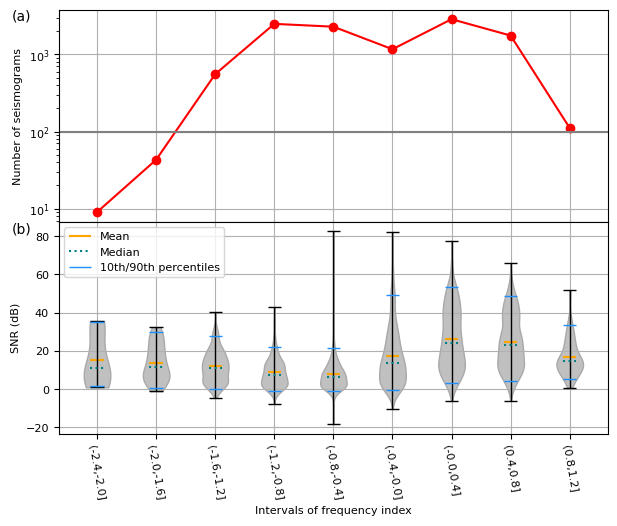

In [26]:
# number of data
exp_name = "vol_eqt"
metrics_vs_fi = pd.read_csv(root_save_path / f"p.{save_csv_names[exp_name]}")


nseis_lower_limit = 100

nseis = metrics_vs_fi["n_seis"].to_numpy()
FIs = metrics_vs_fi["FI"].to_numpy()
intervals = metrics_vs_fi["FI_interval"].to_numpy()

cm = 1 / 2.54
fts = 8
fig, axs = plt.subplots(2, 1, figsize=(18 * cm, 14 * cm), sharex="all")
plt.subplots_adjust(wspace=0.05, hspace=0.0)
ax = axs[0]
ax.semilogy(FIs, nseis, "ro-")
ax.axhline(nseis_lower_limit, color="gray")
# ax.set_xlabel("Frequency index groups")
ax.set_ylabel("Number of seismograms", fontsize=fts)
# ax.set_xticks(FIs)
# ax.set_xticklabels(intervals, rotation=-80)
ax.grid()
ax.tick_params(labelsize=fts)
ax.text(
    -0.05,
    1.0,
    "(a)",
    verticalalignment="top",
    horizontalalignment="right",
    transform=ax.transAxes,
    fontsize=fts + 2,
    # weight="bold",
    color="black",
)


# SNRs
df_with_enough_data = metrics_vs_fi[metrics_vs_fi["n_seis"] > 0]
intervals2 = df_with_enough_data["FI_interval"].to_numpy()
FIs2 = df_with_enough_data["FI"].to_numpy()


def str2list(str_list):
    return [float(x.strip()) for x in str_list.lstrip("[").rstrip("]").split(",")]


snr_list = []
for fi_str in intervals2:
    x, y = fi_str.lstrip("(").rstrip("]").split(",")
    x = float(x)
    y = float(y)
    print(x, y)
    mask = (data_eq.metadata["source_frequency_index"] > x) & (
        lteq(data_eq.metadata["source_frequency_index"], y)
    )
    group = data_eq.metadata[mask].copy()

    snr_zne = group["trace_snr_db"].apply(str2list)
    snr_zne = snr_zne[snr_zne.apply(lambda x: not np.all(pd.isna(np.array(x))))]
    snr = snr_zne.apply(np.nanmean)
    snr = snr[pd.notna(snr)]
    print(min(snr), max(snr))
    snr_list.append(snr.values)

ax = axs[1]
# ax.axvspan(
#     min(FIs[nseis > nseis_lower_limit]),
#     max(FIs[nseis > nseis_lower_limit]),
#     alpha=0.5,
#     color="gray",
# )
violin = ax.violinplot(
    dataset=snr_list,
    positions=FIs2,
    showmeans=True,
    showextrema=True,
    showmedians=True,
    widths=0.18,
    quantiles=[[0.05, 0.95] for _ in range(len(snr_list))],
)
violin["cmeans"].set_linestyle("-")
violin["cmeans"].set_color("orange")
violin["cmeans"].set_label("Mean")


violin["cmedians"].set_linestyle("dotted")
violin["cmedians"].set_color("teal")
violin["cmedians"].set_label("Median")

violin["cquantiles"].set_color("dodgerblue")
violin["cquantiles"].set_linewidth(1)
violin["cquantiles"].set_label("10th/90th percentiles")
for partname in ("cbars", "cmins", "cmaxes"):
    vp = violin[partname]
    vp.set_edgecolor("black")
    vp.set_linewidth(1)
for pc in violin["bodies"]:
    pc.set_facecolor("silver")
    pc.set_edgecolor("darkgray")
    pc.set_alpha(1)

ax.tick_params(labelsize=fts)
ax.text(
    -0.05,
    1.0,
    "(b)",
    verticalalignment="top",
    horizontalalignment="right",
    transform=ax.transAxes,
    fontsize=fts + 2,
    # weight="bold",
    color="black",
)

# for pc in parts['bodies']:
#     pc.set_facecolor('#D43F3A')
#     pc.set_edgecolor('black')
#     pc.set_alpha(1)
# ax.plot(FIs, mean_snrs, "bo-")
# ax.plot(FIs, median_snrs, "go-")
# ax.axhline(nseis_lower_limit, color="black")
ax.set_xlabel("Intervals of frequency index", fontsize=fts)
ax.set_ylabel("SNR (dB)", fontsize=fts)
ax.set_xticks(FIs)
ax.set_xticklabels(intervals, rotation=-80, fontsize=fts)
ax.legend(loc="upper left", fontsize=fts)
ax.grid()

# ax.set_axisbelow(True)
# plt.savefig(root_save_path/"FI_vs_n.jpg", dpi=300, bbox_inches="tight")
plt.savefig(
    root_save_path / "fi_vs_n_and_snr.eps", dpi=600, bbox_inches="tight", pad_inches=0
)

In [27]:
eqt_pred_dirs

['org_eqt', 'int_eqt', 'vol_eqt']

In [28]:
axs.shape

(2,)

-2.4 -2.0
0.9264015910631948 35.60488711608583
-2.0 -1.6
-1.1004516038512306 32.42976224760245
-1.6 -1.2
-4.429147266445951 40.301329875152085
-1.2 -0.8
-7.942315777968847 42.93634537893151
-0.8 -0.4
-18.427903812376403 82.55854371088981
-0.4 -0.0
-10.492208252881246 82.4314861249134
-0.0 0.4
-6.256690098480718 77.7714473439881
0.4 0.8
-6.1923635550996545 66.00297694558213
0.8 1.2
0.7926195433734248 51.74076900880656


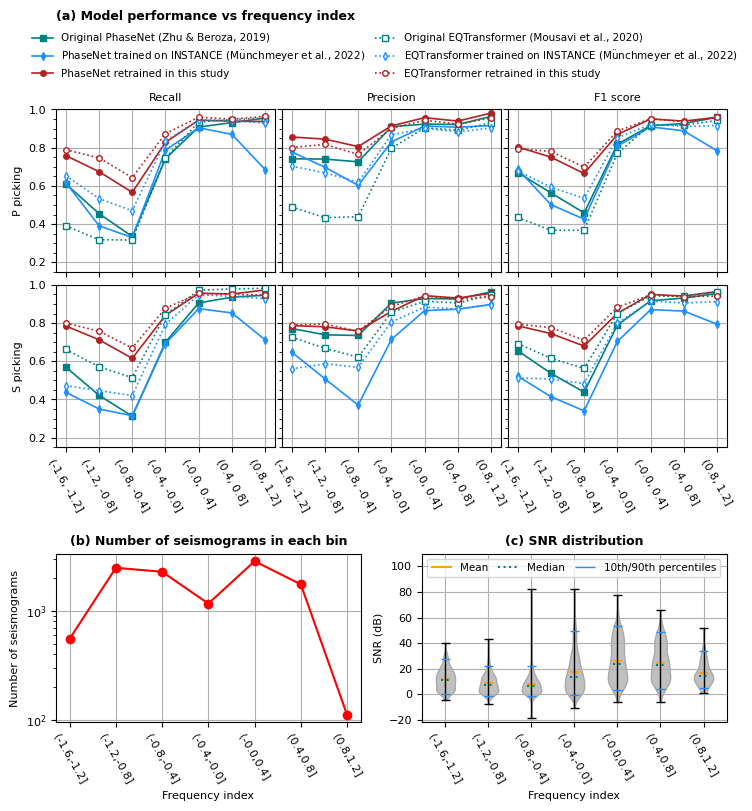

In [31]:
nseis_lower_limit = 100

cm = 1 / 2.54
# fig, axs = plt.subplots(2, 3, figsize=(22 * cm, 10 * cm), sharex="all", sharey="all")
fig = plt.figure(figsize=(22 * cm, 18 * cm))

subfigs = fig.subfigures(2, 1, height_ratios=[1.0, 0.5])
# subfigs.subplots_adjust(hspace=0.5)
axs = subfigs[0].subplots(2, 3, sharex="all", sharey="all")

subfigs[0].subplots_adjust(wspace=0.03, hspace=0.08, bottom=0.165)

labels = {
    "org_eqt": "Original EQTransformer (Mousavi et al., 2020)",
    "int_eqt": r"EQTransformer trained on INSTANCE (M$\rm{\"u}$nchmeyer et al., 2022)",
    "vol_eqt": "EQTransformer retrained in this study",
    "org_pn": "Original PhaseNet (Zhu & Beroza, 2019)",
    "int_pn": r"PhaseNet trained on INSTANCE (M$\rm{\"u}$nchmeyer et al., 2022)",
    "vol_pn": "PhaseNet retrained in this study",
}
lw = 1.2
ms = 4.0
fts = 8

markerfacecolors = [None, "white"]
markeredgecolors = [None, None]
markers = ["s", "d", "o"]
linestyles = ["solid", "dotted"]
colors = ["teal", "dodgerblue", "firebrick"]
for i_net, pred_dirs in enumerate([pn_pred_dirs, eqt_pred_dirs]):
    markerfacecolor = markerfacecolors[i_net]
    markeredgecolor = markeredgecolors[i_net]
    linestyle = linestyles[i_net]

    for i in range(3):
        exp_name = pred_dirs[i]
        color = colors[i]
        marker = markers[i]

        for j, phase in enumerate(["p", "s"]):
            metrics_vs_fi = pd.read_csv(
                root_save_path / f"{phase}.{save_csv_names[exp_name]}"
            )
            metrics_vs_fi = metrics_vs_fi[metrics_vs_fi["n_seis"] > nseis_lower_limit]
            for k, metric in enumerate(["recall", "precision", "F1score"]):
                FIs = metrics_vs_fi["FI"].values
                intervals = (
                    metrics_vs_fi["FI_interval"]
                    .apply(lambda x: x.replace(",", ", "))
                    .values
                )
                ax = axs[j][k]
                metric_value = metrics_vs_fi[f"{phase}_{metric}"]
                ax.plot(
                    FIs,
                    metric_value,
                    color=color,
                    linewidth=lw,
                    linestyle=linestyle,
                    marker=marker,
                    markeredgecolor=markeredgecolor,
                    markerfacecolor=markerfacecolor,
                    markersize=ms,
                    label=labels[exp_name],
                )
                ax.tick_params(labelsize=fts)
                ax.set_xticks(FIs)
                ax.set_xticklabels(intervals, rotation=-60)  # , ha="left"
                ax.yaxis.set_minor_locator(MultipleLocator(0.05))
                ax.set_ylim([0.15, 1])
                ax.grid(True)
axs[0][0].set_ylabel("P picking", fontsize=fts)
axs[1][0].set_ylabel("S picking", fontsize=fts)
axs[0][0].set_title("Recall", fontsize=fts)
axs[0][1].set_title("Precision", fontsize=fts)
axs[0][2].set_title("F1 score", fontsize=fts)
axs[0][0].legend(
    loc="lower left",
    bbox_to_anchor=(-0.15, 1.13, 1, 0.5),
    frameon=False,
    fontsize=fts - 0.5,
    ncols=2,
    columnspacing=0.9,
)
# axs[1][1].set_xlabel("Frequency index", fontsize=fts)
# axs[0][1].set_title("(a) Model performance", y=1.65, loc="center", weight="bold")
axs[0][0].set_title(
    "(a) Model performance vs frequency index",
    y=1.5,
    loc="left",
    weight="bold",
    fontsize=fts + 1,
)
# subplot 1
axs1 = subfigs[1].subplots(1, 2)
subfigs[1].subplots_adjust(wspace=0.2)
subfigs[1].suptitle("")
metrics_vs_fi = pd.read_csv(root_save_path / f"p.{save_csv_names['vol_eqt']}")
nseis = metrics_vs_fi["n_seis"].to_numpy()
FIs = metrics_vs_fi["FI"].to_numpy()
intervals = metrics_vs_fi["FI_interval"].to_numpy()


axs1[0].semilogy(
    FIs[nseis > nseis_lower_limit], nseis[nseis > nseis_lower_limit], "ro-"
)
# axs1[0].axhline(nseis_lower_limit, color="gray")
# ax.set_xlabel("Frequency index groups")
axs1[0].set_ylabel("Number of seismograms", fontsize=fts)
# ax.set_xticks(FIs)
# ax.set_xticklabels(intervals, rotation=-80)
axs1[0].grid()
axs1[0].tick_params(labelsize=fts)
# axs1[0].text(
#     -0.05,
#     1.0,
#     "(a)",
#     verticalalignment="top",
#     horizontalalignment="right",
#     transform=ax.transAxes,
#     fontsize=fts + 2,
#     # weight="bold",
#     color="black",
# )


# SNRs
df_with_enough_data = metrics_vs_fi[metrics_vs_fi["n_seis"] > 0]
intervals2 = df_with_enough_data["FI_interval"].to_numpy()
FIs2 = df_with_enough_data["FI"].to_numpy()


def str2list(str_list):
    return [float(x.strip()) for x in str_list.lstrip("[").rstrip("]").split(",")]


snr_list = []
for fi_str in intervals2:
    x, y = fi_str.lstrip("(").rstrip("]").split(",")
    x = float(x)
    y = float(y)
    print(x, y)
    mask = (data_eq.metadata["source_frequency_index"] > x) & (
        lteq(data_eq.metadata["source_frequency_index"], y)
    )
    group = data_eq.metadata[mask].copy()

    snr_zne = group["trace_snr_db"].apply(str2list)
    snr_zne = snr_zne[snr_zne.apply(lambda x: not np.all(pd.isna(np.array(x))))]
    snr = snr_zne.apply(np.nanmean)
    snr = snr[pd.notna(snr)]
    print(min(snr), max(snr))
    snr_list.append(snr.values)

violin = axs1[1].violinplot(
    dataset=snr_list[2:],
    positions=FIs2[2:],
    showmeans=True,
    showextrema=True,
    showmedians=True,
    widths=0.18,
    quantiles=[[0.05, 0.95] for _ in range(len(snr_list[2:]))],
)
violin["cmeans"].set_linestyle("-")
violin["cmeans"].set_color("orange")
violin["cmeans"].set_label("Mean")


violin["cmedians"].set_linestyle("dotted")
violin["cmedians"].set_color("teal")
violin["cmedians"].set_label("Median")

violin["cquantiles"].set_color("dodgerblue")
violin["cquantiles"].set_linewidth(1)
violin["cquantiles"].set_label("10th/90th percentiles")
for partname in ("cbars", "cmins", "cmaxes"):
    vp = violin[partname]
    vp.set_edgecolor("black")
    vp.set_linewidth(1)
for pc in violin["bodies"]:
    pc.set_facecolor("silver")
    pc.set_edgecolor("darkgray")
    pc.set_alpha(1)

axs1[1].tick_params(labelsize=fts)
# axs1[1].text(
#     -0.05,
#     1.0,
#     "(b)",
#     verticalalignment="top",
#     horizontalalignment="right",
#     transform=ax.transAxes,
#     fontsize=fts + 2,
#     # weight="bold",
#     color="black",
# )

# for pc in parts['bodies']:
#     pc.set_facecolor('#D43F3A')
#     pc.set_edgecolor('black')
#     pc.set_alpha(1)
# ax.plot(FIs, mean_snrs, "bo-")
# ax.plot(FIs, median_snrs, "go-")
# ax.axhline(nseis_lower_limit, color="black")
axs1[0].set_xlabel("Frequency index", fontsize=fts)
axs1[1].set_xlabel("Frequency index", fontsize=fts)
axs1[1].set_ylabel("SNR (dB)", fontsize=fts)

axs1[0].set_xticks(FIs[2:])
axs1[0].set_xticklabels(intervals[2:], rotation=-60, fontsize=fts)
axs1[1].set_xticks(FIs[2:])
axs1[1].set_xticklabels(intervals[2:], rotation=-60, fontsize=fts)
axs1[1].legend(
    loc="upper left",
    # bbox_to_anchor=(-0.0, 1.0, 1, 0.2),
    # frameon=False,
    fontsize=fts - 0.5,
    ncols=3,
    columnspacing=0.9,
)
axs1[1].grid()

axs1[0].set_title(
    "(b) Number of seismograms in each bin",
    loc="center",
    weight="bold",
    fontsize=fts + 1,
)
axs1[1].set_title("(c) SNR distribution", weight="bold", fontsize=fts + 1)
axs1[1].set_ylim([-22, 110])
# plt.tight_layout()
plt.savefig(
    root_save_path / f"metrics_vs_fi_westernus.pdf",
    dpi=600,
    bbox_inches="tight",
    pad_inches=0,
)

In [30]:
FIs

array([-2.2, -1.8, -1.4, -1. , -0.6, -0.2,  0.2,  0.6,  1. ])

In [110]:
len(snr_list[2:])

7

In [111]:
len(FIs2[2:])

7

In [27]:
FIs2[nseis > nseis_lower_limit]

array([-1.4, -1. , -0.6, -0.2,  0.2,  0.6,  1. ])

# Test Performances vs SNR

In [121]:
total_snr_zne = data_eq.metadata["trace_snr_db"].apply(str2list)
total_snr = total_snr_zne.apply(
    lambda x: np.nanmean(x) if not np.all(pd.isna(np.array(x))) else np.nan
)

In [122]:
total_snr_zne2 = data_eq_ENZ.metadata["trace_snr_db"].apply(str2list)
total_snr2 = total_snr_zne2.apply(
    lambda x: np.nanmean(x) if not np.all(pd.isna(np.array(x))) else np.nan
)

In [123]:
np.allclose(total_snr2, total_snr, equal_nan=True)

True

In [124]:
pd.isna(total_snr)

0        False
1        False
2        False
3        False
4        False
         ...  
11297    False
11298    False
11299    False
11300    False
11301    False
Name: trace_snr_db, Length: 11302, dtype: bool

In [125]:
data_eq.metadata[pd.isna(total_snr)]

,index,source_id,source_origin_time,source_latitude_deg,source_longitude_deg,source_depth_km,source_magnitude,source_magnitude_type,source_type,station_network_code,...,trace_s_status,trace_snr_db,trace_mean_snr_db,trace_frequency_index,split,trace_name_original,source_frequency_index,trace_chunk,source_active_volcano_distance_m,trace_component_order


In [126]:
print(np.percentile(total_snr.values, 5))
print(np.percentile(total_snr.values, 95))

-0.01706537309663393
47.29165049245426


(array([ 552., 2019., 2078., 1843., 1212.,  859.,  639.,  475.,  453.,
         423.,  344.]),
 array([-5.,  0.,  5., 10., 15., 20., 25., 30., 35., 40., 45., 50.]),
 <BarContainer object of 11 artists>)

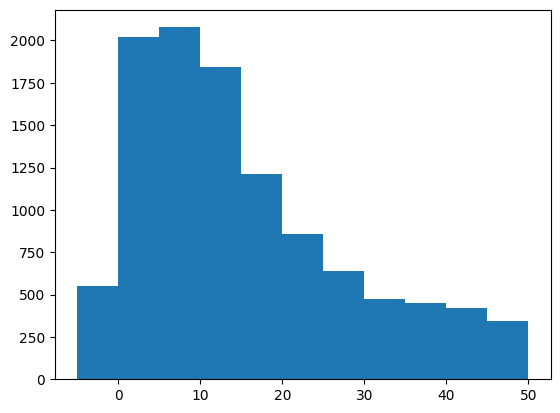

In [127]:
plt.hist(total_snr.values, np.arange(-5, 51, 5))

In [128]:
bins = np.arange(-5, 46, 5)
for x, y in zip(bins[:-1], bins[1:]):
    print(f"{x:15e}, {y:15e}")

  -5.000000e+00,    0.000000e+00
   0.000000e+00,    5.000000e+00
   5.000000e+00,    1.000000e+01
   1.000000e+01,    1.500000e+01
   1.500000e+01,    2.000000e+01
   2.000000e+01,    2.500000e+01
   2.500000e+01,    3.000000e+01
   3.000000e+01,    3.500000e+01
   3.500000e+01,    4.000000e+01
   4.000000e+01,    4.500000e+01


In [129]:
root_save_path_snr = root_save_path / "Test_SNR"

In [130]:
tp_thre = 0.5
print(bins)
t1 = time.perf_counter()
SNRstrings = []
SNRs_midpoint = []
num_seis = {}
total_snr_zne = data_eq.metadata["trace_snr_db"].apply(str2list)
total_snr = total_snr_zne.apply(
    lambda x: np.nanmean(x) if not np.all(pd.isna(np.array(x))) else np.nan
)
for x, y in zip(bins[:-1], bins[1:]):
    mask = pd.notna(total_snr) & (total_snr > x) & (lteq(total_snr, y))

    sub_dataset = data_eq.filter(mask, inplace=False)
    sub_dataset_ENZ = data_eq_ENZ.filter(mask, inplace=False)
    if len(sub_dataset) > 0:
        snr_str = f"({x:.1f},{y:.1f}]"
        SNRstrings.append(snr_str)
        SNRs_midpoint.append(0.5 * (x + y))
        print(snr_str, len(sub_dataset))
        num_seis[snr_str] = len(sub_dataset)

        # sub_dataset._metadata["split"]="test"

        targets_path_snr = root_save_path_snr / f"{snr_str}"
        try:
            targets_path_snr.mkdir(parents=True, exist_ok=False)
        except FileExistsError:
            print(f"{targets_path_snr} exists")
        generate_task0(
            dataset=sub_dataset,
            output=targets_path_snr,
            sampling_rate=100,
            noise_before_events=False,
            replace_if_exist=True,
        )

        # for model in original_model_list:
        #     eval_task0(dev_test_set=sub_dataset,
        #                 model=model,
        #                 exp_name=f"{model.name}_original",
        #                 targets_path=targets_path_snr,
        #                 prob_thres=np.array([0.2, 0.225, 0.25,0.275, 0.3,0.35, 0.4, 0.5]),
        #                 num_workers=16,
        #                 batchsize=2048,
        #                 num_test_run=-1,
        #                 output_remark="pred",
        #                 sets=["test"],
        #                 data_norm_type=model.norm)

        # retrained eqt

        model = vol_eqt
        # for target_i, dataset_i in zip(target_path_list,dataset_list):
        eval_task0(
            dev_test_set=sub_dataset,
            model=model,
            exp_name=f"vol_eqt",
            targets_path=targets_path_snr,
            prob_thres=np.array([0.22]),
            num_workers=12,
            batchsize=1024,
            num_test_run=-1,
            output_remark="pred",
            tp_thre=tp_thre,
            sets=["test"],
            data_norm_type=model.norm,
        )

        model = vol_pn
        eval_task0(
            dev_test_set=sub_dataset,
            model=model,
            exp_name=f"vol_pn",
            targets_path=targets_path_snr,
            prob_thres=np.array([0.39, 0.34]),
            num_workers=12,
            batchsize=1024,
            num_test_run=-1,
            output_remark="pred",
            tp_thre=tp_thre,
            sets=["test"],
            data_norm_type=model.norm,
        )

        model = org_eqt2
        eval_task0(
            dev_test_set=sub_dataset,
            model=model,
            exp_name=f"org_eqt",
            targets_path=targets_path_snr,
            prob_thres=np.array([0.26, 0.15]),
            num_workers=12,
            batchsize=1024,
            num_test_run=-1,
            output_remark="pred",
            tp_thre=tp_thre,
            sets=["test"],
            # sets=["train", "dev","test"],
            # append_to_file=True,
            data_norm_type=model.norm,
        )

        model = org_pn
        eval_task0(
            dev_test_set=sub_dataset_ENZ,
            model=model,
            exp_name=f"org_pn",
            targets_path=targets_path_snr,
            prob_thres=np.array([0.25, 0.19]),
            num_workers=12,
            batchsize=1024,
            num_test_run=-1,
            output_remark="pred",
            tp_thre=tp_thre,
            sets=["test"],
            # sets=["train", "dev","test"],
            # append_to_file=True,
            data_norm_type=model.norm,
        )

        model = eqt_instance
        eval_task0(
            dev_test_set=sub_dataset,
            model=model,
            exp_name=f"int_eqt",
            targets_path=targets_path_snr,
            prob_thres=np.array([0.04]),
            num_workers=12,
            batchsize=1024,
            num_test_run=-1,
            output_remark="pred",
            tp_thre=tp_thre,
            sets=["test"],
            # sets=["train", "dev","test"],
            # append_to_file=True,
            data_norm_type=model.norm,
        )

        model = pn_instance
        eval_task0(
            dev_test_set=sub_dataset,
            model=model,
            exp_name=f"int_pn",
            targets_path=targets_path_snr,
            prob_thres=np.array([0.13, 0.05]),
            num_workers=12,
            batchsize=1024,
            num_test_run=-1,
            output_remark="pred",
            tp_thre=tp_thre,
            sets=["test"],
            # sets=["train", "dev","test"],
            # append_to_file=True,
            data_norm_type=model.norm,
        )

t2 = time.perf_counter()
running_time = str(datetime.timedelta(seconds=t2 - t1))
print(f"Finished. Runing time {running_time}")

[-5  0  5 10 15 20 25 30 35 40 45]
(-5.0,0.0] 573
Test_SNR/(-5.0,0.0] exists
The existing file will be replaced.


100%|██████████| 573/573 [00:00<00:00, 2574.04it/s]


Test_SNR/(-5.0,0.0]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 573/573 [00:00<00:00, 337073.80it/s]

Number of examples in test: 573
573 earthquake traces
0 noise traces
Probability threshold: 0.2200


Test_SNR/(-5.0,0.0]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 573/573 [00:00<00:00, 330901.31it/s]

Number of examples in test: 573
573 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
Test_SNR/(-5.0,0.0]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 573/573 [00:00<00:00, 339071.13it/s]

Number of examples in test: 573
573 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
Test_SNR/(-5.0,0.0]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 573/573 [00:00<00:00, 341819.97it/s]

Number of examples in test: 573
573 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
Test_SNR/(-5.0,0.0]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 573/573 [00:00<00:00, 342501.95it/s]

Number of examples in test: 573
573 earthquake traces
0 noise traces
Probability threshold: 0.0400


Test_SNR/(-5.0,0.0]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 573/573 [00:00<00:00, 343480.95it/s]

Number of examples in test: 573
573 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
(0.0,5.0] 1998
Test_SNR/(0.0,5.0] exists
The existing file will be replaced.


100%|██████████| 1998/1998 [00:00<00:00, 2576.54it/s]


Test_SNR/(0.0,5.0]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 1998/1998 [00:00<00:00, 346590.82it/s]


Number of examples in test: 1998
1998 earthquake traces
0 noise traces
Probability threshold: 0.2200
Test_SNR/(0.0,5.0]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 1998/1998 [00:00<00:00, 362968.62it/s]

Number of examples in test: 1998
1998 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
Test_SNR/(0.0,5.0]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 1998/1998 [00:00<00:00, 354043.91it/s]

Number of examples in test: 1998
1998 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
Test_SNR/(0.0,5.0]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 1998/1998 [00:00<00:00, 348856.02it/s]

Number of examples in test: 1998
1998 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
Test_SNR/(0.0,5.0]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 1998/1998 [00:00<00:00, 360222.64it/s]

Number of examples in test: 1998
1998 earthquake traces
0 noise traces
Probability threshold: 0.0400


Test_SNR/(0.0,5.0]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 1998/1998 [00:00<00:00, 360160.71it/s]

Number of examples in test: 1998
1998 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
(5.0,10.0] 2078
Test_SNR/(5.0,10.0] exists
The existing file will be replaced.


100%|██████████| 2078/2078 [00:00<00:00, 2557.29it/s]


Test_SNR/(5.0,10.0]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 2078/2078 [00:00<00:00, 361499.95it/s]

Number of examples in test: 2078
2078 earthquake traces
0 noise traces
Probability threshold: 0.2200


Test_SNR/(5.0,10.0]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 2078/2078 [00:00<00:00, 353093.65it/s]

Number of examples in test: 2078
2078 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
Test_SNR/(5.0,10.0]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 2078/2078 [00:00<00:00, 356531.28it/s]

Number of examples in test: 2078
2078 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
Test_SNR/(5.0,10.0]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 2078/2078 [00:00<00:00, 352836.36it/s]

Number of examples in test: 2078
2078 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
Test_SNR/(5.0,10.0]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 2078/2078 [00:00<00:00, 365119.34it/s]

Number of examples in test: 2078
2078 earthquake traces
0 noise traces
Probability threshold: 0.0400


Test_SNR/(5.0,10.0]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 2078/2078 [00:00<00:00, 354890.82it/s]

Number of examples in test: 2078
2078 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
(10.0,15.0] 1843
Test_SNR/(10.0,15.0] exists
The existing file will be replaced.


100%|██████████| 1843/1843 [00:00<00:00, 2542.92it/s]


Test_SNR/(10.0,15.0]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 1843/1843 [00:00<00:00, 347639.07it/s]

Number of examples in test: 1842
1842 earthquake traces
0 noise traces
Probability threshold: 0.2200


Test_SNR/(10.0,15.0]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 1843/1843 [00:00<00:00, 357461.38it/s]

Number of examples in test: 1842
1842 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
Test_SNR/(10.0,15.0]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 1843/1843 [00:00<00:00, 366477.14it/s]

Number of examples in test: 1842
1842 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
Test_SNR/(10.0,15.0]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 1843/1843 [00:00<00:00, 368012.49it/s]

Number of examples in test: 1842
1842 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
Test_SNR/(10.0,15.0]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 1843/1843 [00:00<00:00, 364060.77it/s]

Number of examples in test: 1842
1842 earthquake traces
0 noise traces
Probability threshold: 0.0400


Test_SNR/(10.0,15.0]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 1843/1843 [00:00<00:00, 357759.16it/s]

Number of examples in test: 1842
1842 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
(15.0,20.0] 1212
Test_SNR/(15.0,20.0] exists
The existing file will be replaced.


100%|██████████| 1212/1212 [00:00<00:00, 2611.67it/s]


Test_SNR/(15.0,20.0]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 1212/1212 [00:00<00:00, 360838.76it/s]

Number of examples in test: 1212
1212 earthquake traces
0 noise traces
Probability threshold: 0.2200


Test_SNR/(15.0,20.0]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 1212/1212 [00:00<00:00, 355887.46it/s]

Number of examples in test: 1212
1212 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
Test_SNR/(15.0,20.0]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 1212/1212 [00:00<00:00, 356736.59it/s]

Number of examples in test: 1212
1212 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
Test_SNR/(15.0,20.0]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 1212/1212 [00:00<00:00, 350344.35it/s]

Number of examples in test: 1212
1212 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
Test_SNR/(15.0,20.0]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 1212/1212 [00:00<00:00, 354918.41it/s]

Number of examples in test: 1212
1212 earthquake traces
0 noise traces
Probability threshold: 0.0400


Test_SNR/(15.0,20.0]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 1212/1212 [00:00<00:00, 361403.13it/s]

Number of examples in test: 1212
1212 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
(20.0,25.0] 859
Test_SNR/(20.0,25.0] exists
The existing file will be replaced.


100%|██████████| 859/859 [00:00<00:00, 2573.15it/s]


Test_SNR/(20.0,25.0]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 859/859 [00:00<00:00, 349627.09it/s]

Number of examples in test: 859
859 earthquake traces
0 noise traces
Probability threshold: 0.2200


Test_SNR/(20.0,25.0]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 859/859 [00:00<00:00, 353053.12it/s]

Number of examples in test: 859
859 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
Test_SNR/(20.0,25.0]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 859/859 [00:00<00:00, 342677.11it/s]

Number of examples in test: 859
859 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
Test_SNR/(20.0,25.0]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 859/859 [00:00<00:00, 352949.37it/s]

Number of examples in test: 859
859 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
Test_SNR/(20.0,25.0]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 859/859 [00:00<00:00, 350136.75it/s]

Number of examples in test: 859
859 earthquake traces
0 noise traces
Probability threshold: 0.0400


Test_SNR/(20.0,25.0]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 859/859 [00:00<00:00, 350545.55it/s]

Number of examples in test: 859
859 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
(25.0,30.0] 639
Test_SNR/(25.0,30.0] exists
The existing file will be replaced.


100%|██████████| 639/639 [00:00<00:00, 2632.09it/s]


Test_SNR/(25.0,30.0]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 639/639 [00:00<00:00, 350301.95it/s]

Number of examples in test: 639
639 earthquake traces
0 noise traces
Probability threshold: 0.2200


Test_SNR/(25.0,30.0]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 639/639 [00:00<00:00, 338703.43it/s]

Number of examples in test: 639
639 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
Test_SNR/(25.0,30.0]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 639/639 [00:00<00:00, 341813.58it/s]

Number of examples in test: 639
639 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
Test_SNR/(25.0,30.0]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 639/639 [00:00<00:00, 335733.47it/s]

Number of examples in test: 639
639 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
Test_SNR/(25.0,30.0]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 639/639 [00:00<00:00, 341117.51it/s]

Number of examples in test: 639
639 earthquake traces
0 noise traces
Probability threshold: 0.0400


Test_SNR/(25.0,30.0]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 639/639 [00:00<00:00, 324907.29it/s]

Number of examples in test: 639
639 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
(30.0,35.0] 475
Test_SNR/(30.0,35.0] exists
The existing file will be replaced.


100%|██████████| 475/475 [00:00<00:00, 2682.14it/s]


Test_SNR/(30.0,35.0]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 475/475 [00:00<00:00, 335516.07it/s]

Number of examples in test: 475
475 earthquake traces
0 noise traces
Probability threshold: 0.2200


Test_SNR/(30.0,35.0]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 475/475 [00:00<00:00, 337162.70it/s]

Number of examples in test: 475
475 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
Test_SNR/(30.0,35.0]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 475/475 [00:00<00:00, 341555.70it/s]

Number of examples in test: 475
475 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
Test_SNR/(30.0,35.0]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 475/475 [00:00<00:00, 328707.21it/s]

Number of examples in test: 475
475 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
Test_SNR/(30.0,35.0]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 475/475 [00:00<00:00, 338480.19it/s]

Number of examples in test: 475
475 earthquake traces
0 noise traces
Probability threshold: 0.0400


Test_SNR/(30.0,35.0]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 475/475 [00:00<00:00, 331938.42it/s]

Number of examples in test: 475
475 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
(35.0,40.0] 453
Test_SNR/(35.0,40.0] exists
The existing file will be replaced.


100%|██████████| 453/453 [00:00<00:00, 2707.96it/s]


Test_SNR/(35.0,40.0]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 453/453 [00:00<00:00, 336108.21it/s]

Number of examples in test: 453
453 earthquake traces
0 noise traces
Probability threshold: 0.2200


Test_SNR/(35.0,40.0]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 453/453 [00:00<00:00, 326744.58it/s]

Number of examples in test: 453
453 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
Test_SNR/(35.0,40.0]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 453/453 [00:00<00:00, 339047.06it/s]

Number of examples in test: 453
453 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
Test_SNR/(35.0,40.0]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 453/453 [00:00<00:00, 335929.93it/s]

Number of examples in test: 453
453 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
Test_SNR/(35.0,40.0]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 453/453 [00:00<00:00, 339047.06it/s]

Number of examples in test: 453
453 earthquake traces
0 noise traces
Probability threshold: 0.0400


Test_SNR/(35.0,40.0]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 453/453 [00:00<00:00, 338503.42it/s]

Number of examples in test: 453
453 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
(40.0,45.0] 423
Test_SNR/(40.0,45.0] exists
The existing file will be replaced.


100%|██████████| 423/423 [00:00<00:00, 2734.32it/s]


Test_SNR/(40.0,45.0]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 423/423 [00:00<00:00, 337555.29it/s]

Number of examples in test: 423
423 earthquake traces
0 noise traces
Probability threshold: 0.2200


Test_SNR/(40.0,45.0]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 423/423 [00:00<00:00, 333808.20it/s]

Number of examples in test: 423
423 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
Test_SNR/(40.0,45.0]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 423/423 [00:00<00:00, 339038.91it/s]

Number of examples in test: 423
423 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
Test_SNR/(40.0,45.0]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 423/423 [00:00<00:00, 334248.42it/s]

Number of examples in test: 423
423 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
Test_SNR/(40.0,45.0]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 423/423 [00:00<00:00, 336211.97it/s]

Number of examples in test: 423
423 earthquake traces
0 noise traces
Probability threshold: 0.0400


Test_SNR/(40.0,45.0]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 423/423 [00:00<00:00, 338198.74it/s]

Number of examples in test: 423
423 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
Finished. Runing time 0:07:36.573994


In [131]:
opt_thresholds_for_original_models_df = pd.read_csv(
    "/home/zhongyiyuan/volpick/model_training/Original_model_opt_thresholds/all_pred/task0/optimal_threshold.csv"
)
opt_thresholds_for_original_models_df = opt_thresholds_for_original_models_df[
    ["exp_name", "model", "p_opt_prob_thre", "s_opt_prob_thre"]  # "pretraining",
]
opt_thresholds_for_original_models_df

,exp_name,model,p_opt_prob_thre,s_opt_prob_thre
0,PhaseNet_org_instance,PhaseNet,0.13,0.050
1,PhaseNet_org_incorrect_component_order,PhaseNet,0.28,0.170
2,EQTransformer_org,EQTransformer,0.01,0.001
3,EQTransformer_org_instance,EQTransformer,0.04,0.040
4,PhaseNet_org,PhaseNet,0.25,0.190
5,EQTransformer_org_nonconservative,EQTransformer,0.26,0.150
6,PhaseNet_org_stead,PhaseNet,0.01,0.040
7,EQTransformer_org_stead,EQTransformer,0.02,0.010


In [132]:
eqt_pred_dirs = ["org_eqt", "int_eqt", "vol_eqt"]
pn_pred_dirs = ["org_pn", "int_pn", "vol_pn"]
exp_names = eqt_pred_dirs + pn_pred_dirs

save_csv_names = {
    "org_pn": "org_pn_snr.csv",
    "int_pn": "int_pn_snr.csv",
    "vol_pn": "vol_pn_snr.csv",
    "org_eqt": "org_eqt_snr.csv",
    "vol_eqt": "vol_eqt_snr.csv",
    "int_eqt": "int_eqt_snr.csv",
}
p_thre_dict = {
    "vol_eqt": 0.22,
    "vol_pn": 0.39,
    "org_eqt": 0.26,
    "org_pn": 0.25,
    "int_eqt": 0.04,
    "int_pn": 0.13,
}
s_thre_dict = {
    "vol_eqt": 0.22,
    "vol_pn": 0.34,
    "org_eqt": 0.15,
    "org_pn": 0.19,
    "int_eqt": 0.04,
    "int_pn": 0.05,
}

In [133]:
root_save_path_snr

PosixPath('Test_SNR')

In [134]:
# run only once
for exp_name in exp_names:
    p_metrics_vs_snr = []
    s_metrics_vs_snr = []
    for i, (snr_str, snr) in enumerate(zip(SNRstrings, SNRs_midpoint)):
        # print(i,snr_str,snr)
        tmp_metrics = pd.read_csv(
            root_save_path_snr
            / f"{snr_str}_pred"
            / "task0"
            / exp_name
            / "test_metrics.csv"
        )

        column_labels = tmp_metrics.columns
        p_labels = [x for x in column_labels if x.startswith("p_")]
        s_labels = [x for x in column_labels if x.startswith("s_")]

        p_tmp_dict = (
            tmp_metrics[np.isclose(tmp_metrics["prob_thre"], p_thre_dict[exp_name])][
                ["prob_thre"] + p_labels
            ]
            .squeeze()
            .to_dict()
        )
        p_tmp_dict["SNR"] = snr
        p_tmp_dict["SNR_interval"] = snr_str
        p_tmp_dict["n_seis"] = num_seis[snr_str]

        s_tmp_dict = (
            tmp_metrics[np.isclose(tmp_metrics["prob_thre"], s_thre_dict[exp_name])][
                ["prob_thre"] + s_labels
            ]
            .squeeze()
            .to_dict()
        )
        s_tmp_dict["SNR"] = snr
        s_tmp_dict["SNR_interval"] = snr_str
        s_tmp_dict["n_seis"] = num_seis[snr_str]

        p_metrics_vs_snr.append(p_tmp_dict)
        s_metrics_vs_snr.append(s_tmp_dict)
    p_metrics_vs_snr = pd.DataFrame(p_metrics_vs_snr)
    p_metrics_vs_snr.to_csv(
        root_save_path_snr / f"p.{save_csv_names[exp_name]}", index=False
    )
    s_metrics_vs_snr = pd.DataFrame(s_metrics_vs_snr)
    s_metrics_vs_snr.to_csv(
        root_save_path_snr / f"s.{save_csv_names[exp_name]}", index=False
    )

In [135]:
root_save_path_snr = root_save_path / "Test_SNR_lp"

In [136]:
tp_thre = 0.5
print(bins)
t1 = time.perf_counter()
SNRstrings = []
SNRs_midpoint = []
num_seis = {}
total_snr_zne = data_eq_lp.metadata["trace_snr_db"].apply(str2list)
total_snr = total_snr_zne.apply(
    lambda x: np.nanmean(x) if not np.all(pd.isna(np.array(x))) else np.nan
)
for x, y in zip(bins[:-1], bins[1:]):
    mask = pd.notna(total_snr) & (total_snr > x) & (lteq(total_snr, y))

    sub_dataset = data_eq_lp.filter(mask, inplace=False)
    sub_dataset_ENZ = data_eq_ENZ_lp.filter(mask, inplace=False)
    if len(sub_dataset) > 0:
        snr_str = f"({x:.1f},{y:.1f}]"
        SNRstrings.append(snr_str)
        SNRs_midpoint.append(0.5 * (x + y))
        print(snr_str, len(sub_dataset))
        num_seis[snr_str] = len(sub_dataset)

        # sub_dataset._metadata["split"]="test"

        targets_path_snr = root_save_path_snr / f"{snr_str}"
        try:
            targets_path_snr.mkdir(parents=True, exist_ok=False)
        except FileExistsError:
            print(f"{targets_path_snr} exists")
        generate_task0(
            dataset=sub_dataset,
            output=targets_path_snr,
            sampling_rate=100,
            noise_before_events=False,
            replace_if_exist=True,
        )

        # for model in original_model_list:
        #     eval_task0(dev_test_set=sub_dataset,
        #                 model=model,
        #                 exp_name=f"{model.name}_original",
        #                 targets_path=targets_path_snr,
        #                 prob_thres=np.array([0.2, 0.225, 0.25,0.275, 0.3,0.35, 0.4, 0.5]),
        #                 num_workers=16,
        #                 batchsize=2048,
        #                 num_test_run=-1,
        #                 output_remark="pred",
        #                 sets=["test"],
        #                 data_norm_type=model.norm)

        # retrained eqt

        model = vol_eqt
        # for target_i, dataset_i in zip(target_path_list,dataset_list):
        eval_task0(
            dev_test_set=sub_dataset,
            model=model,
            exp_name=f"vol_eqt",
            targets_path=targets_path_snr,
            prob_thres=np.array([0.22]),
            num_workers=12,
            batchsize=1024,
            num_test_run=-1,
            output_remark="pred",
            tp_thre=tp_thre,
            sets=["test"],
            data_norm_type=model.norm,
        )

        model = vol_pn
        eval_task0(
            dev_test_set=sub_dataset,
            model=model,
            exp_name=f"vol_pn",
            targets_path=targets_path_snr,
            prob_thres=np.array([0.39, 0.34]),
            num_workers=12,
            batchsize=1024,
            num_test_run=-1,
            output_remark="pred",
            tp_thre=tp_thre,
            sets=["test"],
            data_norm_type=model.norm,
        )

        model = org_eqt2
        eval_task0(
            dev_test_set=sub_dataset,
            model=model,
            exp_name=f"org_eqt",
            targets_path=targets_path_snr,
            prob_thres=np.array([0.26, 0.15]),
            num_workers=12,
            batchsize=1024,
            num_test_run=-1,
            output_remark="pred",
            tp_thre=tp_thre,
            sets=["test"],
            # sets=["train", "dev","test"],
            # append_to_file=True,
            data_norm_type=model.norm,
        )

        model = org_pn
        eval_task0(
            dev_test_set=sub_dataset_ENZ,
            model=model,
            exp_name=f"org_pn",
            targets_path=targets_path_snr,
            prob_thres=np.array([0.25, 0.19]),
            num_workers=12,
            batchsize=1024,
            num_test_run=-1,
            output_remark="pred",
            tp_thre=tp_thre,
            sets=["test"],
            # sets=["train", "dev","test"],
            # append_to_file=True,
            data_norm_type=model.norm,
        )

        model = eqt_instance
        eval_task0(
            dev_test_set=sub_dataset,
            model=model,
            exp_name=f"int_eqt",
            targets_path=targets_path_snr,
            prob_thres=np.array([0.04]),
            num_workers=12,
            batchsize=1024,
            num_test_run=-1,
            output_remark="pred",
            tp_thre=tp_thre,
            sets=["test"],
            # sets=["train", "dev","test"],
            # append_to_file=True,
            data_norm_type=model.norm,
        )

        model = pn_instance
        eval_task0(
            dev_test_set=sub_dataset,
            model=model,
            exp_name=f"int_pn",
            targets_path=targets_path_snr,
            prob_thres=np.array([0.13, 0.05]),
            num_workers=12,
            batchsize=1024,
            num_test_run=-1,
            output_remark="pred",
            tp_thre=tp_thre,
            sets=["test"],
            # sets=["train", "dev","test"],
            # append_to_file=True,
            data_norm_type=model.norm,
        )

t2 = time.perf_counter()
running_time = str(datetime.timedelta(seconds=t2 - t1))
print(f"Finished. Runing time {running_time}")

[-5  0  5 10 15 20 25 30 35 40 45]
(-5.0,0.0] 474
Test_SNR_lp/(-5.0,0.0] exists
The existing file will be replaced.


100%|██████████| 474/474 [00:00<00:00, 2731.00it/s]


Test_SNR_lp/(-5.0,0.0]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 474/474 [00:00<00:00, 350326.01it/s]

Number of examples in test: 474
474 earthquake traces
0 noise traces
Probability threshold: 0.2200


Test_SNR_lp/(-5.0,0.0]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 474/474 [00:00<00:00, 344319.38it/s]

Number of examples in test: 474
474 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
Test_SNR_lp/(-5.0,0.0]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 474/474 [00:00<00:00, 345997.23it/s]

Number of examples in test: 474
474 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
Test_SNR_lp/(-5.0,0.0]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 474/474 [00:00<00:00, 328340.23it/s]

Number of examples in test: 474
474 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
Test_SNR_lp/(-5.0,0.0]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 474/474 [00:00<00:00, 343486.54it/s]

Number of examples in test: 474
474 earthquake traces
0 noise traces
Probability threshold: 0.0400


Test_SNR_lp/(-5.0,0.0]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 474/474 [00:00<00:00, 345576.24it/s]

Number of examples in test: 474
474 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
(0.0,5.0] 1638
Test_SNR_lp/(0.0,5.0] exists
The existing file will be replaced.


100%|██████████| 1638/1638 [00:00<00:00, 2720.87it/s]


Test_SNR_lp/(0.0,5.0]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 1638/1638 [00:00<00:00, 355364.92it/s]

Number of examples in test: 1638
1638 earthquake traces
0 noise traces
Probability threshold: 0.2200


Test_SNR_lp/(0.0,5.0]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 1638/1638 [00:00<00:00, 363198.88it/s]

Number of examples in test: 1638
1638 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
Test_SNR_lp/(0.0,5.0]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 1638/1638 [00:00<00:00, 355696.09it/s]

Number of examples in test: 1638
1638 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
Test_SNR_lp/(0.0,5.0]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 1638/1638 [00:00<00:00, 364509.23it/s]

Number of examples in test: 1638
1638 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
Test_SNR_lp/(0.0,5.0]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 1638/1638 [00:00<00:00, 370744.70it/s]

Number of examples in test: 1638
1638 earthquake traces
0 noise traces
Probability threshold: 0.0400


Test_SNR_lp/(0.0,5.0]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 1638/1638 [00:00<00:00, 363333.33it/s]

Number of examples in test: 1638
1638 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
(5.0,10.0] 1466
Test_SNR_lp/(5.0,10.0] exists
The existing file will be replaced.


100%|██████████| 1466/1466 [00:00<00:00, 2660.25it/s]


Test_SNR_lp/(5.0,10.0]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 1466/1466 [00:00<00:00, 361697.04it/s]

Number of examples in test: 1466
1466 earthquake traces
0 noise traces
Probability threshold: 0.2200


Test_SNR_lp/(5.0,10.0]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 1466/1466 [00:00<00:00, 361867.33it/s]

Number of examples in test: 1466
1466 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
Test_SNR_lp/(5.0,10.0]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 1466/1466 [00:00<00:00, 365437.40it/s]

Number of examples in test: 1466
1466 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
Test_SNR_lp/(5.0,10.0]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 1466/1466 [00:00<00:00, 361569.43it/s]

Number of examples in test: 1466
1466 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
Test_SNR_lp/(5.0,10.0]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 1466/1466 [00:00<00:00, 362892.45it/s]

Number of examples in test: 1466
1466 earthquake traces
0 noise traces
Probability threshold: 0.0400


Test_SNR_lp/(5.0,10.0]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 1466/1466 [00:00<00:00, 353605.71it/s]

Number of examples in test: 1466
1466 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
(10.0,15.0] 1078
Test_SNR_lp/(10.0,15.0] exists
The existing file will be replaced.


100%|██████████| 1078/1078 [00:00<00:00, 2749.99it/s]


Test_SNR_lp/(10.0,15.0]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 1078/1078 [00:00<00:00, 364869.25it/s]

Number of examples in test: 1077
1077 earthquake traces
0 noise traces
Probability threshold: 0.2200


Test_SNR_lp/(10.0,15.0]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 1078/1078 [00:00<00:00, 359216.63it/s]

Number of examples in test: 1077
1077 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
Test_SNR_lp/(10.0,15.0]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 1078/1078 [00:00<00:00, 362064.36it/s]

Number of examples in test: 1077
1077 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
Test_SNR_lp/(10.0,15.0]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 1078/1078 [00:00<00:00, 353764.16it/s]

Number of examples in test: 1077
1077 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
Test_SNR_lp/(10.0,15.0]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 1078/1078 [00:00<00:00, 352880.65it/s]

Number of examples in test: 1077
1077 earthquake traces
0 noise traces
Probability threshold: 0.0400


Test_SNR_lp/(10.0,15.0]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 1078/1078 [00:00<00:00, 357060.71it/s]

Number of examples in test: 1077
1077 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
(15.0,20.0] 541
Test_SNR_lp/(15.0,20.0] exists
The existing file will be replaced.


100%|██████████| 541/541 [00:00<00:00, 2786.27it/s]


Test_SNR_lp/(15.0,20.0]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 541/541 [00:00<00:00, 344955.68it/s]

Number of examples in test: 541
541 earthquake traces
0 noise traces
Probability threshold: 0.2200


Test_SNR_lp/(15.0,20.0]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 541/541 [00:00<00:00, 351965.02it/s]

Number of examples in test: 541
541 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
Test_SNR_lp/(15.0,20.0]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 541/541 [00:00<00:00, 346853.94it/s]

Number of examples in test: 541
541 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
Test_SNR_lp/(15.0,20.0]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 541/541 [00:00<00:00, 346960.01it/s]

Number of examples in test: 541
541 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
Test_SNR_lp/(15.0,20.0]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 541/541 [00:00<00:00, 342870.73it/s]

Number of examples in test: 541
541 earthquake traces
0 noise traces
Probability threshold: 0.0400


Test_SNR_lp/(15.0,20.0]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 541/541 [00:00<00:00, 346060.46it/s]

Number of examples in test: 541
541 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
(20.0,25.0] 242
Test_SNR_lp/(20.0,25.0] exists
The existing file will be replaced.


100%|██████████| 242/242 [00:00<00:00, 2761.97it/s]


Test_SNR_lp/(20.0,25.0]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 242/242 [00:00<00:00, 323049.51it/s]

Number of examples in test: 242
242 earthquake traces
0 noise traces
Probability threshold: 0.2200


Test_SNR_lp/(20.0,25.0]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 242/242 [00:00<00:00, 304719.77it/s]

Number of examples in test: 242
242 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
Test_SNR_lp/(20.0,25.0]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 242/242 [00:00<00:00, 304354.29it/s]

Number of examples in test: 242
242 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
Test_SNR_lp/(20.0,25.0]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 242/242 [00:00<00:00, 319088.83it/s]

Number of examples in test: 242
242 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
Test_SNR_lp/(20.0,25.0]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 242/242 [00:00<00:00, 323461.30it/s]

Number of examples in test: 242
242 earthquake traces
0 noise traces
Probability threshold: 0.0400


Test_SNR_lp/(20.0,25.0]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 242/242 [00:00<00:00, 322229.07it/s]

Number of examples in test: 242
242 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
(25.0,30.0] 101
Test_SNR_lp/(25.0,30.0] exists
The existing file will be replaced.


100%|██████████| 101/101 [00:00<00:00, 2756.86it/s]


Test_SNR_lp/(25.0,30.0]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 101/101 [00:00<00:00, 292356.59it/s]

Number of examples in test: 101
101 earthquake traces
0 noise traces
Probability threshold: 0.2200


Test_SNR_lp/(25.0,30.0]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 101/101 [00:00<00:00, 282228.32it/s]

Number of examples in test: 101
101 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
Test_SNR_lp/(25.0,30.0]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 101/101 [00:00<00:00, 250813.92it/s]

Number of examples in test: 101
101 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
Test_SNR_lp/(25.0,30.0]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 101/101 [00:00<00:00, 278883.94it/s]

Number of examples in test: 101
101 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
Test_SNR_lp/(25.0,30.0]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 101/101 [00:00<00:00, 276698.04it/s]

Number of examples in test: 101
101 earthquake traces
0 noise traces
Probability threshold: 0.0400


Test_SNR_lp/(25.0,30.0]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 101/101 [00:00<00:00, 272778.30it/s]

Number of examples in test: 101
101 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
(30.0,35.0] 48
Test_SNR_lp/(30.0,35.0] exists
The existing file will be replaced.


100%|██████████| 48/48 [00:00<00:00, 2565.72it/s]


Test_SNR_lp/(30.0,35.0]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 48/48 [00:00<00:00, 250095.15it/s]

Number of examples in test: 48
48 earthquake traces
0 noise traces
Probability threshold: 0.2200


Test_SNR_lp/(30.0,35.0]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 48/48 [00:00<00:00, 236576.49it/s]

Number of examples in test: 48
48 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
Test_SNR_lp/(30.0,35.0]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 48/48 [00:00<00:00, 236021.80it/s]

Number of examples in test: 48
48 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
Test_SNR_lp/(30.0,35.0]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 48/48 [00:00<00:00, 237133.80it/s]

Number of examples in test: 48
48 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
Test_SNR_lp/(30.0,35.0]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 48/48 [00:00<00:00, 234920.18it/s]

Number of examples in test: 48
48 earthquake traces
0 noise traces
Probability threshold: 0.0400


Test_SNR_lp/(30.0,35.0]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 48/48 [00:00<00:00, 206066.11it/s]

Number of examples in test: 48
48 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
(35.0,40.0] 34
Test_SNR_lp/(35.0,40.0] exists
The existing file will be replaced.


100%|██████████| 34/34 [00:00<00:00, 2551.33it/s]


Test_SNR_lp/(35.0,40.0]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 34/34 [00:00<00:00, 218052.50it/s]

Number of examples in test: 34
34 earthquake traces
0 noise traces
Probability threshold: 0.2200


Test_SNR_lp/(35.0,40.0]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 34/34 [00:00<00:00, 207880.96it/s]

Number of examples in test: 34
34 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
Test_SNR_lp/(35.0,40.0]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 34/34 [00:00<00:00, 210024.06it/s]

Number of examples in test: 34
34 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
Test_SNR_lp/(35.0,40.0]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 34/34 [00:00<00:00, 206675.85it/s]

Number of examples in test: 34
34 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
Test_SNR_lp/(35.0,40.0]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 34/34 [00:00<00:00, 183298.63it/s]

Number of examples in test: 34
34 earthquake traces
0 noise traces
Probability threshold: 0.0400


Test_SNR_lp/(35.0,40.0]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 34/34 [00:00<00:00, 181664.12it/s]

Number of examples in test: 34
34 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
(40.0,45.0] 11
Test_SNR_lp/(40.0,45.0] exists
The existing file will be replaced.


100%|██████████| 11/11 [00:00<00:00, 2261.19it/s]


Test_SNR_lp/(40.0,45.0]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 11/11 [00:00<00:00, 129236.26it/s]

Number of examples in test: 11
11 earthquake traces
0 noise traces
Probability threshold: 0.2200


Test_SNR_lp/(40.0,45.0]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 11/11 [00:00<00:00, 122056.47it/s]

Number of examples in test: 11
11 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
Test_SNR_lp/(40.0,45.0]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 11/11 [00:00<00:00, 120778.39it/s]

Number of examples in test: 11
11 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
Test_SNR_lp/(40.0,45.0]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 11/11 [00:00<00:00, 117998.32it/s]

Number of examples in test: 11
11 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
Test_SNR_lp/(40.0,45.0]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 11/11 [00:00<00:00, 116508.44it/s]

Number of examples in test: 11
11 earthquake traces
0 noise traces
Probability threshold: 0.0400


Test_SNR_lp/(40.0,45.0]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 11/11 [00:00<00:00, 117397.82it/s]

Number of examples in test: 11
11 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
Finished. Runing time 0:06:09.415241


In [137]:
root_save_path_snr = root_save_path / "Test_SNR_lp"

In [138]:
eqt_pred_dirs = ["org_eqt", "int_eqt", "vol_eqt"]
pn_pred_dirs = ["org_pn", "int_pn", "vol_pn"]
exp_names = eqt_pred_dirs + pn_pred_dirs

save_csv_names = {
    "org_pn": "org_pn_snr.csv",
    "int_pn": "int_pn_snr.csv",
    "vol_pn": "vol_pn_snr.csv",
    "org_eqt": "org_eqt_snr.csv",
    "vol_eqt": "vol_eqt_snr.csv",
    "int_eqt": "int_eqt_snr.csv",
}
p_thre_dict = {
    "vol_eqt": 0.22,
    "vol_pn": 0.39,
    "org_eqt": 0.26,
    "org_pn": 0.25,
    "int_eqt": 0.04,
    "int_pn": 0.13,
}
s_thre_dict = {
    "vol_eqt": 0.22,
    "vol_pn": 0.34,
    "org_eqt": 0.15,
    "org_pn": 0.19,
    "int_eqt": 0.04,
    "int_pn": 0.05,
}

In [139]:
root_save_path_snr

PosixPath('Test_SNR_lp')

In [140]:
# run only once
for exp_name in exp_names:
    p_metrics_vs_snr = []
    s_metrics_vs_snr = []
    for i, (snr_str, snr) in enumerate(zip(SNRstrings, SNRs_midpoint)):
        # print(i,snr_str,snr)
        tmp_metrics = pd.read_csv(
            root_save_path_snr
            / f"{snr_str}_pred"
            / "task0"
            / exp_name
            / "test_metrics.csv"
        )

        column_labels = tmp_metrics.columns
        p_labels = [x for x in column_labels if x.startswith("p_")]
        s_labels = [x for x in column_labels if x.startswith("s_")]

        p_tmp_dict = (
            tmp_metrics[np.isclose(tmp_metrics["prob_thre"], p_thre_dict[exp_name])][
                ["prob_thre"] + p_labels
            ]
            .squeeze()
            .to_dict()
        )
        p_tmp_dict["SNR"] = snr
        p_tmp_dict["SNR_interval"] = snr_str
        p_tmp_dict["n_seis"] = num_seis[snr_str]

        s_tmp_dict = (
            tmp_metrics[np.isclose(tmp_metrics["prob_thre"], s_thre_dict[exp_name])][
                ["prob_thre"] + s_labels
            ]
            .squeeze()
            .to_dict()
        )
        s_tmp_dict["SNR"] = snr
        s_tmp_dict["SNR_interval"] = snr_str
        s_tmp_dict["n_seis"] = num_seis[snr_str]

        p_metrics_vs_snr.append(p_tmp_dict)
        s_metrics_vs_snr.append(s_tmp_dict)
    p_metrics_vs_snr = pd.DataFrame(p_metrics_vs_snr)
    p_metrics_vs_snr.to_csv(
        root_save_path_snr / f"p.{save_csv_names[exp_name]}", index=False
    )
    s_metrics_vs_snr = pd.DataFrame(s_metrics_vs_snr)
    s_metrics_vs_snr.to_csv(
        root_save_path_snr / f"s.{save_csv_names[exp_name]}", index=False
    )

VT

In [141]:
root_save_path_snr = root_save_path / "Test_SNR_vt"
root_save_path_snr

PosixPath('Test_SNR_vt')

In [142]:
tp_thre = 0.5
print(bins)
t1 = time.perf_counter()
SNRstrings = []
SNRs_midpoint = []
num_seis = {}
total_snr_zne = data_eq_rg.metadata["trace_snr_db"].apply(str2list)
total_snr = total_snr_zne.apply(
    lambda x: np.nanmean(x) if not np.all(pd.isna(np.array(x))) else np.nan
)
for x, y in zip(bins[:-1], bins[1:]):
    mask = pd.notna(total_snr) & (total_snr > x) & (lteq(total_snr, y))

    sub_dataset = data_eq_rg.filter(mask, inplace=False)
    sub_dataset_ENZ = data_eq_ENZ_rg.filter(mask, inplace=False)
    if len(sub_dataset) > 0:
        snr_str = f"({x:.1f},{y:.1f}]"
        SNRstrings.append(snr_str)
        SNRs_midpoint.append(0.5 * (x + y))
        print(snr_str, len(sub_dataset))
        num_seis[snr_str] = len(sub_dataset)

        # sub_dataset._metadata["split"]="test"

        targets_path_snr = root_save_path_snr / f"{snr_str}"
        try:
            targets_path_snr.mkdir(parents=True, exist_ok=False)
        except FileExistsError:
            print(f"{targets_path_snr} exists")
        generate_task0(
            dataset=sub_dataset,
            output=targets_path_snr,
            sampling_rate=100,
            noise_before_events=False,
            replace_if_exist=True,
        )

        # for model in original_model_list:
        #     eval_task0(dev_test_set=sub_dataset,
        #                 model=model,
        #                 exp_name=f"{model.name}_original",
        #                 targets_path=targets_path_snr,
        #                 prob_thres=np.array([0.2, 0.225, 0.25,0.275, 0.3,0.35, 0.4, 0.5]),
        #                 num_workers=16,
        #                 batchsize=2048,
        #                 num_test_run=-1,
        #                 output_remark="pred",
        #                 sets=["test"],
        #                 data_norm_type=model.norm)

        # retrained eqt

        model = vol_eqt
        # for target_i, dataset_i in zip(target_path_list,dataset_list):
        eval_task0(
            dev_test_set=sub_dataset,
            model=model,
            exp_name=f"vol_eqt",
            targets_path=targets_path_snr,
            prob_thres=np.array([0.22]),
            num_workers=12,
            batchsize=1024,
            num_test_run=-1,
            output_remark="pred",
            tp_thre=tp_thre,
            sets=["test"],
            data_norm_type=model.norm,
        )

        model = vol_pn
        eval_task0(
            dev_test_set=sub_dataset,
            model=model,
            exp_name=f"vol_pn",
            targets_path=targets_path_snr,
            prob_thres=np.array([0.39, 0.34]),
            num_workers=12,
            batchsize=1024,
            num_test_run=-1,
            output_remark="pred",
            tp_thre=tp_thre,
            sets=["test"],
            data_norm_type=model.norm,
        )

        model = org_eqt2
        eval_task0(
            dev_test_set=sub_dataset,
            model=model,
            exp_name=f"org_eqt",
            targets_path=targets_path_snr,
            prob_thres=np.array([0.26, 0.15]),
            num_workers=12,
            batchsize=1024,
            num_test_run=-1,
            output_remark="pred",
            tp_thre=tp_thre,
            sets=["test"],
            # sets=["train", "dev","test"],
            # append_to_file=True,
            data_norm_type=model.norm,
        )

        model = org_pn
        eval_task0(
            dev_test_set=sub_dataset_ENZ,
            model=model,
            exp_name=f"org_pn",
            targets_path=targets_path_snr,
            prob_thres=np.array([0.25, 0.19]),
            num_workers=12,
            batchsize=1024,
            num_test_run=-1,
            output_remark="pred",
            tp_thre=tp_thre,
            sets=["test"],
            # sets=["train", "dev","test"],
            # append_to_file=True,
            data_norm_type=model.norm,
        )

        model = eqt_instance
        eval_task0(
            dev_test_set=sub_dataset,
            model=model,
            exp_name=f"int_eqt",
            targets_path=targets_path_snr,
            prob_thres=np.array([0.04]),
            num_workers=12,
            batchsize=1024,
            num_test_run=-1,
            output_remark="pred",
            tp_thre=tp_thre,
            sets=["test"],
            # sets=["train", "dev","test"],
            # append_to_file=True,
            data_norm_type=model.norm,
        )

        model = pn_instance
        eval_task0(
            dev_test_set=sub_dataset,
            model=model,
            exp_name=f"int_pn",
            targets_path=targets_path_snr,
            prob_thres=np.array([0.13, 0.05]),
            num_workers=12,
            batchsize=1024,
            num_test_run=-1,
            output_remark="pred",
            tp_thre=tp_thre,
            sets=["test"],
            # sets=["train", "dev","test"],
            # append_to_file=True,
            data_norm_type=model.norm,
        )

t2 = time.perf_counter()
running_time = str(datetime.timedelta(seconds=t2 - t1))
print(f"Finished. Runing time {running_time}")

[-5  0  5 10 15 20 25 30 35 40 45]
(-5.0,0.0] 99
Test_SNR_vt/(-5.0,0.0] exists
The existing file will be replaced.


100%|██████████| 99/99 [00:00<00:00, 2501.84it/s]


Test_SNR_vt/(-5.0,0.0]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 99/99 [00:00<00:00, 295541.71it/s]

Number of examples in test: 99
99 earthquake traces
0 noise traces
Probability threshold: 0.2200


Test_SNR_vt/(-5.0,0.0]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 99/99 [00:00<00:00, 256953.03it/s]

Number of examples in test: 99
99 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
Test_SNR_vt/(-5.0,0.0]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 99/99 [00:00<00:00, 280375.49it/s]

Number of examples in test: 99
99 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
Test_SNR_vt/(-5.0,0.0]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 99/99 [00:00<00:00, 284408.28it/s]

Number of examples in test: 99
99 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
Test_SNR_vt/(-5.0,0.0]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 99/99 [00:00<00:00, 276271.52it/s]

Number of examples in test: 99
99 earthquake traces
0 noise traces
Probability threshold: 0.0400


Test_SNR_vt/(-5.0,0.0]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 99/99 [00:00<00:00, 275538.22it/s]

Number of examples in test: 99
99 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
(0.0,5.0] 360
Test_SNR_vt/(0.0,5.0] exists
The existing file will be replaced.


100%|██████████| 360/360 [00:00<00:00, 2553.45it/s]


Test_SNR_vt/(0.0,5.0]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 360/360 [00:00<00:00, 339619.76it/s]

Number of examples in test: 360
360 earthquake traces
0 noise traces
Probability threshold: 0.2200


Test_SNR_vt/(0.0,5.0]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 360/360 [00:00<00:00, 334651.91it/s]

Number of examples in test: 360
360 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
Test_SNR_vt/(0.0,5.0]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 360/360 [00:00<00:00, 329611.32it/s]

Number of examples in test: 360
360 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
Test_SNR_vt/(0.0,5.0]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 360/360 [00:00<00:00, 327112.10it/s]

Number of examples in test: 360
360 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
Test_SNR_vt/(0.0,5.0]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 360/360 [00:00<00:00, 326687.46it/s]

Number of examples in test: 360
360 earthquake traces
0 noise traces
Probability threshold: 0.0400


Test_SNR_vt/(0.0,5.0]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 360/360 [00:00<00:00, 330332.41it/s]

Number of examples in test: 360
360 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
(5.0,10.0] 612
Test_SNR_vt/(5.0,10.0] exists
The existing file will be replaced.


100%|██████████| 612/612 [00:00<00:00, 2587.00it/s]


Test_SNR_vt/(5.0,10.0]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 612/612 [00:00<00:00, 345572.70it/s]

Number of examples in test: 612
612 earthquake traces
0 noise traces
Probability threshold: 0.2200


Test_SNR_vt/(5.0,10.0]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 612/612 [00:00<00:00, 349572.93it/s]

Number of examples in test: 612
612 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
Test_SNR_vt/(5.0,10.0]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 612/612 [00:00<00:00, 347914.62it/s]

Number of examples in test: 612
612 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
Test_SNR_vt/(5.0,10.0]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 612/612 [00:00<00:00, 329979.95it/s]

Number of examples in test: 612
612 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
Test_SNR_vt/(5.0,10.0]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 612/612 [00:00<00:00, 346646.06it/s]

Number of examples in test: 612
612 earthquake traces
0 noise traces
Probability threshold: 0.0400


Test_SNR_vt/(5.0,10.0]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 612/612 [00:00<00:00, 345061.71it/s]

Number of examples in test: 612
612 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
(10.0,15.0] 765
Test_SNR_vt/(10.0,15.0] exists
The existing file will be replaced.


100%|██████████| 765/765 [00:00<00:00, 2620.23it/s]


Test_SNR_vt/(10.0,15.0]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 765/765 [00:00<00:00, 355725.34it/s]

Number of examples in test: 765
765 earthquake traces
0 noise traces
Probability threshold: 0.2200


Test_SNR_vt/(10.0,15.0]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 765/765 [00:00<00:00, 355292.06it/s]

Number of examples in test: 765
765 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
Test_SNR_vt/(10.0,15.0]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 765/765 [00:00<00:00, 350212.02it/s]

Number of examples in test: 765
765 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
Test_SNR_vt/(10.0,15.0]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 765/765 [00:00<00:00, 352172.38it/s]

Number of examples in test: 765
765 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
Test_SNR_vt/(10.0,15.0]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 765/765 [00:00<00:00, 345461.09it/s]

Number of examples in test: 765
765 earthquake traces
0 noise traces
Probability threshold: 0.0400


Test_SNR_vt/(10.0,15.0]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 765/765 [00:00<00:00, 337148.53it/s]

Number of examples in test: 765
765 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
(15.0,20.0] 671
Test_SNR_vt/(15.0,20.0] exists
The existing file will be replaced.


100%|██████████| 671/671 [00:00<00:00, 2607.99it/s]


Test_SNR_vt/(15.0,20.0]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 671/671 [00:00<00:00, 340023.92it/s]

Number of examples in test: 671
671 earthquake traces
0 noise traces
Probability threshold: 0.2200


Test_SNR_vt/(15.0,20.0]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 671/671 [00:00<00:00, 353077.15it/s]

Number of examples in test: 671
671 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
Test_SNR_vt/(15.0,20.0]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 671/671 [00:00<00:00, 354232.60it/s]

Number of examples in test: 671
671 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
Test_SNR_vt/(15.0,20.0]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 671/671 [00:00<00:00, 348702.51it/s]

Number of examples in test: 671
671 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
Test_SNR_vt/(15.0,20.0]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 671/671 [00:00<00:00, 340930.10it/s]

Number of examples in test: 671
671 earthquake traces
0 noise traces
Probability threshold: 0.0400


Test_SNR_vt/(15.0,20.0]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 671/671 [00:00<00:00, 347969.58it/s]

Number of examples in test: 671
671 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
(20.0,25.0] 617
Test_SNR_vt/(20.0,25.0] exists
The existing file will be replaced.


100%|██████████| 617/617 [00:00<00:00, 2597.87it/s]


Test_SNR_vt/(20.0,25.0]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 617/617 [00:00<00:00, 351758.27it/s]

Number of examples in test: 617
617 earthquake traces
0 noise traces
Probability threshold: 0.2200


Test_SNR_vt/(20.0,25.0]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 617/617 [00:00<00:00, 348536.78it/s]

Number of examples in test: 617
617 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
Test_SNR_vt/(20.0,25.0]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 617/617 [00:00<00:00, 339572.97it/s]

Number of examples in test: 617
617 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
Test_SNR_vt/(20.0,25.0]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 617/617 [00:00<00:00, 347320.57it/s]

Number of examples in test: 617
617 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
Test_SNR_vt/(20.0,25.0]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 617/617 [00:00<00:00, 330762.47it/s]

Number of examples in test: 617
617 earthquake traces
0 noise traces
Probability threshold: 0.0400


Test_SNR_vt/(20.0,25.0]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 617/617 [00:00<00:00, 350947.32it/s]

Number of examples in test: 617
617 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
(25.0,30.0] 538
Test_SNR_vt/(25.0,30.0] exists
The existing file will be replaced.


100%|██████████| 538/538 [00:00<00:00, 2663.55it/s]


Test_SNR_vt/(25.0,30.0]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 538/538 [00:00<00:00, 341795.75it/s]

Number of examples in test: 538
538 earthquake traces
0 noise traces
Probability threshold: 0.2200


Test_SNR_vt/(25.0,30.0]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 538/538 [00:00<00:00, 347962.31it/s]

Number of examples in test: 538
538 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
Test_SNR_vt/(25.0,30.0]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 538/538 [00:00<00:00, 345141.57it/s]

Number of examples in test: 538
538 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
Test_SNR_vt/(25.0,30.0]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 538/538 [00:00<00:00, 341640.51it/s]

Number of examples in test: 538
538 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
Test_SNR_vt/(25.0,30.0]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 538/538 [00:00<00:00, 330144.19it/s]

Number of examples in test: 538
538 earthquake traces
0 noise traces
Probability threshold: 0.0400


Test_SNR_vt/(25.0,30.0]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 538/538 [00:00<00:00, 343617.41it/s]

Number of examples in test: 538
538 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
(30.0,35.0] 427
Test_SNR_vt/(30.0,35.0] exists
The existing file will be replaced.


100%|██████████| 427/427 [00:00<00:00, 2675.37it/s]


Test_SNR_vt/(30.0,35.0]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 427/427 [00:00<00:00, 334635.24it/s]

Number of examples in test: 427
427 earthquake traces
0 noise traces
Probability threshold: 0.2200


Test_SNR_vt/(30.0,35.0]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 427/427 [00:00<00:00, 333948.87it/s]

Number of examples in test: 427
427 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
Test_SNR_vt/(30.0,35.0]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 427/427 [00:00<00:00, 340747.30it/s]

Number of examples in test: 427
427 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
Test_SNR_vt/(30.0,35.0]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 427/427 [00:00<00:00, 333699.98it/s]

Number of examples in test: 427
427 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
Test_SNR_vt/(30.0,35.0]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 427/427 [00:00<00:00, 339519.96it/s]

Number of examples in test: 427
427 earthquake traces
0 noise traces
Probability threshold: 0.0400


Test_SNR_vt/(30.0,35.0]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 427/427 [00:00<00:00, 339134.22it/s]

Number of examples in test: 427
427 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
(35.0,40.0] 419
Test_SNR_vt/(35.0,40.0] exists
The existing file will be replaced.


100%|██████████| 419/419 [00:00<00:00, 2704.24it/s]


Test_SNR_vt/(35.0,40.0]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 419/419 [00:00<00:00, 344185.93it/s]

Number of examples in test: 419
419 earthquake traces
0 noise traces
Probability threshold: 0.2200


Test_SNR_vt/(35.0,40.0]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 419/419 [00:00<00:00, 319995.15it/s]

Number of examples in test: 419
419 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
Test_SNR_vt/(35.0,40.0]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 419/419 [00:00<00:00, 332402.76it/s]

Number of examples in test: 419
419 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
Test_SNR_vt/(35.0,40.0]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 419/419 [00:00<00:00, 335128.41it/s]

Number of examples in test: 419
419 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
Test_SNR_vt/(35.0,40.0]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 419/419 [00:00<00:00, 331963.24it/s]

Number of examples in test: 419
419 earthquake traces
0 noise traces
Probability threshold: 0.0400


Test_SNR_vt/(35.0,40.0]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 419/419 [00:00<00:00, 338615.29it/s]

Number of examples in test: 419
419 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
(40.0,45.0] 412
Test_SNR_vt/(40.0,45.0] exists
The existing file will be replaced.


100%|██████████| 412/412 [00:00<00:00, 2722.65it/s]


Test_SNR_vt/(40.0,45.0]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 412/412 [00:00<00:00, 343549.35it/s]

Number of examples in test: 412
412 earthquake traces
0 noise traces
Probability threshold: 0.2200


Test_SNR_vt/(40.0,45.0]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 412/412 [00:00<00:00, 335283.91it/s]

Number of examples in test: 412
412 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
Test_SNR_vt/(40.0,45.0]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 412/412 [00:00<00:00, 335935.70it/s]

Number of examples in test: 412
412 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
Test_SNR_vt/(40.0,45.0]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 412/412 [00:00<00:00, 321617.95it/s]

Number of examples in test: 412
412 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
Test_SNR_vt/(40.0,45.0]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 412/412 [00:00<00:00, 329027.66it/s]

Number of examples in test: 412
412 earthquake traces
0 noise traces
Probability threshold: 0.0400


Test_SNR_vt/(40.0,45.0]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 412/412 [00:00<00:00, 337972.47it/s]

Number of examples in test: 412
412 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
Finished. Runing time 0:06:04.726204


In [143]:
opt_thresholds_for_original_models_df = pd.read_csv(
    "/home/zhongyiyuan/volpick/model_training/Original_model_opt_thresholds/all_pred/task0/optimal_threshold.csv"
)
opt_thresholds_for_original_models_df = opt_thresholds_for_original_models_df[
    ["exp_name", "model", "p_opt_prob_thre", "s_opt_prob_thre"]  # "pretraining",
]
opt_thresholds_for_original_models_df

eqt_pred_dirs = ["org_eqt", "int_eqt", "vol_eqt"]
pn_pred_dirs = ["org_pn", "int_pn", "vol_pn"]
exp_names = eqt_pred_dirs + pn_pred_dirs

save_csv_names = {
    "org_pn": "org_pn_snr.csv",
    "int_pn": "int_pn_snr.csv",
    "vol_pn": "vol_pn_snr.csv",
    "org_eqt": "org_eqt_snr.csv",
    "vol_eqt": "vol_eqt_snr.csv",
    "int_eqt": "int_eqt_snr.csv",
}
p_thre_dict = {
    "vol_eqt": 0.22,
    "vol_pn": 0.39,
    "org_eqt": 0.26,
    "org_pn": 0.25,
    "int_eqt": 0.04,
    "int_pn": 0.13,
}
s_thre_dict = {
    "vol_eqt": 0.22,
    "vol_pn": 0.34,
    "org_eqt": 0.15,
    "org_pn": 0.19,
    "int_eqt": 0.04,
    "int_pn": 0.05,
}

In [144]:
root_save_path_snr = root_save_path / "Test_SNR_vt"

# run only once
for exp_name in exp_names:
    p_metrics_vs_snr = []
    s_metrics_vs_snr = []
    for i, (snr_str, snr) in enumerate(zip(SNRstrings, SNRs_midpoint)):
        # print(i,snr_str,snr)
        tmp_metrics = pd.read_csv(
            root_save_path_snr
            / f"{snr_str}_pred"
            / "task0"
            / exp_name
            / "test_metrics.csv"
        )

        column_labels = tmp_metrics.columns
        p_labels = [x for x in column_labels if x.startswith("p_")]
        s_labels = [x for x in column_labels if x.startswith("s_")]

        p_tmp_dict = (
            tmp_metrics[np.isclose(tmp_metrics["prob_thre"], p_thre_dict[exp_name])][
                ["prob_thre"] + p_labels
            ]
            .squeeze()
            .to_dict()
        )
        p_tmp_dict["SNR"] = snr
        p_tmp_dict["SNR_interval"] = snr_str
        p_tmp_dict["n_seis"] = num_seis[snr_str]

        s_tmp_dict = (
            tmp_metrics[np.isclose(tmp_metrics["prob_thre"], s_thre_dict[exp_name])][
                ["prob_thre"] + s_labels
            ]
            .squeeze()
            .to_dict()
        )
        s_tmp_dict["SNR"] = snr
        s_tmp_dict["SNR_interval"] = snr_str
        s_tmp_dict["n_seis"] = num_seis[snr_str]

        p_metrics_vs_snr.append(p_tmp_dict)
        s_metrics_vs_snr.append(s_tmp_dict)
    p_metrics_vs_snr = pd.DataFrame(p_metrics_vs_snr)
    p_metrics_vs_snr.to_csv(
        root_save_path_snr / f"p.{save_csv_names[exp_name]}", index=False
    )
    s_metrics_vs_snr = pd.DataFrame(s_metrics_vs_snr)
    s_metrics_vs_snr.to_csv(
        root_save_path_snr / f"s.{save_csv_names[exp_name]}", index=False
    )

In [145]:
metrics_vs_snr

,prob_thre,s_TP,s_FP,s_FN,s_precision,s_recall,s_F1score,s_mean,s_median,s_std,...,s_modified_MAD,s_modified_mean2,s_modified_median2,s_modified_std2,s_modified_RMSE2,s_modified_MAE2,s_modified_MAD2,SNR,SNR_interval,n_seis
1,0.22,1201.0,333.0,652.0,0.782920,0.648138,0.709182,-0.807936,-0.03,4.440538,...,0.10,-0.074350,-0.05,0.197805,0.211243,0.136300,0.08,2.5,"(0.0,5.0]",360
2,0.22,1531.0,366.0,391.0,0.807064,0.796566,0.801781,-0.435843,-0.02,4.102066,...,0.10,-0.068813,-0.04,0.201967,0.213309,0.136209,0.08,7.5,"(5.0,10.0]",612
3,0.22,1492.0,257.0,225.0,0.853059,0.868957,0.860935,-0.215583,-0.01,2.874194,...,0.09,-0.047450,-0.02,0.206054,0.211383,0.136192,0.08,12.5,"(10.0,15.0]",765
4,0.22,1034.0,135.0,112.0,0.884517,0.902269,0.893305,-0.163105,0.00,2.465032,...,0.08,-0.031350,-0.01,0.185747,0.188289,0.119616,0.07,17.5,"(15.0,20.0]",671
5,0.22,758.0,81.0,69.0,0.903456,0.916566,0.909964,-0.366880,0.00,2.791291,...,0.07,-0.028524,-0.01,0.183843,0.185927,0.114351,0.07,22.5,"(20.0,25.0]",617
6,0.22,583.0,54.0,34.0,0.915228,0.944895,0.929825,-0.345405,0.00,2.448083,...,0.06,-0.030567,-0.02,0.170476,0.173055,0.104967,0.06,27.5,"(25.0,30.0]",538
7,0.22,442.0,32.0,21.0,0.932489,0.954644,0.943436,-0.364862,-0.01,2.628824,...,0.06,-0.041286,-0.02,0.141870,0.147605,0.091929,0.05,32.5,"(30.0,35.0]",427
8,0.22,437.0,20.0,10.0,0.956236,0.977629,0.966814,-0.017643,-0.01,1.939246,...,0.06,-0.034977,-0.02,0.145944,0.149917,0.093221,0.06,37.5,"(35.0,40.0]",419
9,0.22,410.0,9.0,9.0,0.978520,0.978520,0.978520,-0.183580,-0.01,2.006125,...,0.05,-0.033592,-0.02,0.097395,0.102914,0.071602,0.05,42.5,"(40.0,45.0]",412


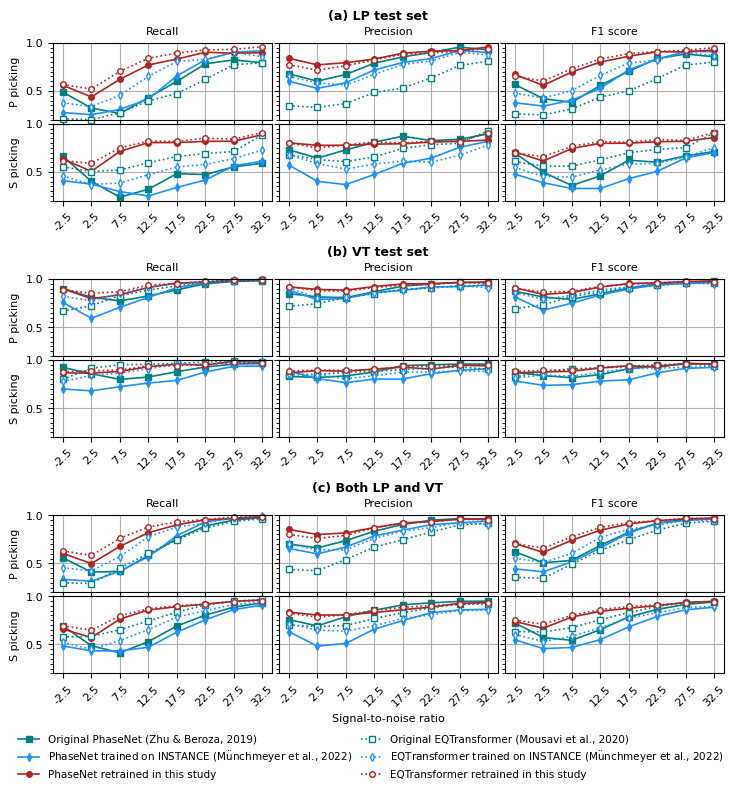

In [154]:
nseis_lower_limit = 40
cm = 1 / 2.54

fig = plt.figure(figsize=(22 * cm, 18 * cm))
subfigs = fig.subfigures(3, 1, height_ratios=[1.0, 1.0, 1.0])

# fig, axs = plt.subplots(2, 3, figsize=(22 * cm, 8 * cm), sharex="all", sharey="all")

# plt.subplots_adjust(wspace=0.03, hspace=0.08)

labels = {
    "org_eqt": "Original EQTransformer (Mousavi et al., 2020)",
    "int_eqt": r"EQTransformer trained on INSTANCE (M$\rm{\"u}$nchmeyer et al., 2022)",
    "vol_eqt": "EQTransformer retrained in this study",
    "org_pn": "Original PhaseNet (Zhu & Beroza, 2019)",
    "int_pn": r"PhaseNet trained on INSTANCE (M$\rm{\"u}$nchmeyer et al., 2022)",
    "vol_pn": "PhaseNet retrained in this study",
}
lw = 1.2
ms = 4.0
fts = 8

markerfacecolors = [None, "white"]
markeredgecolors = [None, None]
markers = ["s", "d", "o"]
linestyles = ["solid", "dotted"]
colors = ["teal", "dodgerblue", "firebrick"]

root_save_path_snr_list = [
    root_save_path / "Test_SNR_lp",
    root_save_path / "Test_SNR_vt",
    root_save_path / "Test_SNR",
]
titles = ["(a) LP test set", "(b) VT test set", "(c) Both LP and VT"]
for i_fig in range(3):
    root_save_path_snr = root_save_path_snr_list[i_fig]
    axs = subfigs[i_fig].subplots(2, 3, sharex="all", sharey="all")
    # axs[0][1].set_title(
    #     titles[i_fig],
    #     y=1.2,
    #     x=0.5,
    #     # loc="center",
    #     weight="bold",
    #     fontsize=fts + 1,
    # )
    subfigs[i_fig].suptitle(
        titles[i_fig], x=0.5, y=1.02, fontsize=fts + 1, weight="bold"
    )
    subfigs[i_fig].subplots_adjust(wspace=0.03, hspace=0.05, bottom=0.21)
    for i_net, pred_dirs in enumerate([pn_pred_dirs, eqt_pred_dirs]):
        markerfacecolor = markerfacecolors[i_net]
        markeredgecolor = markeredgecolors[i_net]
        linestyle = linestyles[i_net]

        for i in range(3):
            exp_name = pred_dirs[i]
            color = colors[i]
            marker = markers[i]

            for j, phase in enumerate(["p", "s"]):
                metrics_vs_snr = pd.read_csv(
                    root_save_path_snr / f"{phase}.{save_csv_names[exp_name]}"
                )
                metrics_vs_snr = metrics_vs_snr[
                    (metrics_vs_snr["n_seis"] > nseis_lower_limit)
                    & (metrics_vs_snr["SNR"] < 35)
                ]
                for k, metric in enumerate(["recall", "precision", "F1score"]):
                    SNRs = metrics_vs_snr["SNR"].values
                    intervals = (
                        metrics_vs_snr["SNR_interval"]
                        .apply(lambda x: x.replace(",", ", "))
                        .values
                    )
                    ax = axs[j][k]
                    metric_value = metrics_vs_snr[f"{phase}_{metric}"]
                    ax.plot(
                        SNRs,
                        metric_value,
                        color=color,
                        linewidth=lw,
                        linestyle=linestyle,
                        marker=marker,
                        markeredgecolor=markeredgecolor,
                        markerfacecolor=markerfacecolor,
                        markersize=ms,
                        label=labels[exp_name],
                        clip_on=False,
                    )
                    ax.tick_params(labelsize=fts)
                    ax.set_xticks(SNRs)
                    # ax.set_xticklabels(intervals, rotation=-90)  # , ha="left"
                    ax.set_xticklabels(SNRs, rotation=45)  # , ha="left"
                    ax.yaxis.set_minor_locator(MultipleLocator(0.05))
                    ax.set_ylim([0.2, 1])
                    ax.grid(True)
    axs[0][0].set_ylabel("P picking", fontsize=fts)
    axs[1][0].set_ylabel("S picking", fontsize=fts)
    axs[0][0].set_title("Recall", fontsize=fts)
    axs[0][1].set_title("Precision", fontsize=fts)
    axs[0][2].set_title("F1 score", fontsize=fts)
    if i_fig == 2:
        axs[-1][0].legend(
            loc="lower left",
            bbox_to_anchor=(-0.2, -1.5, 1, 0.5),
            frameon=False,
            fontsize=fts - 0.5,
            ncols=2,
            columnspacing=0.9,
        )
        axs[1][1].set_xlabel("Signal-to-noise ratio", fontsize=fts)

plt.savefig(
    f"metrics_vs_snr_westernus.pdf",
    dpi=600,
    bbox_inches="tight",
    pad_inches=0,
)
plt.savefig(
    f"metrics_vs_snr_westernus.jpg",
    dpi=600,
    bbox_inches="tight",
    pad_inches=0,
)